Packages that will be used during the notebook

In [1]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import seaborn as sns

from imblearn.under_sampling import ClusterCentroids, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn import tree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, KFold
from sklearn.metrics import recall_score, roc_auc_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

from itertools import combinations 
from collections import Counter

Project Settings

In [2]:
feature_engineering = True

**Create directories to save Task1 models training results**

In [3]:
#create results folder
results_folder = 'results'
Path(results_folder).mkdir(parents=True, exist_ok=True)

#create folder to save binary results
results_binary_folder = '{}/binary'.format(results_folder)
Path(results_binary_folder).mkdir(parents=True, exist_ok=True)

#create folder to save multiclass results
results_multi_folder = '{}/multi'.format(results_folder)
Path(results_multi_folder).mkdir(parents=True, exist_ok=True)

# **Task 0 (Know your Data) - Exploratory Data Analysis**

---

In this section  we will:

*    Explore the classes distribution;
*    Explore our data.

## Read data


Load CSVs and create three datasets:

* df_main: with all data available;
* df_main_dogs: just dogs data;
* df_main_cats: just cats data.

In [4]:
df_main = pd.read_csv('data/PetFinder_dataset.csv')
df_color_labels = pd.read_csv('data/color_labels.csv')
df_state_labels = pd.read_csv('data/state_labels.csv')

#Type 1 is Dog, 2 is Cat
df_breed_labels = pd.read_csv('data/breed_labels.csv')
df_breed_labels['Type'] = ['Dog' if s == 1 else 'Cat' for s in df_breed_labels['Type']]

#create columns
df_main['Type'] = ['Dog' if i == 1 else 'Cat' for i in df_main['Type']]
df_main['Adopted'] = [True if i != 4 else False for i in df_main['AdoptionSpeed']]

#change PhotoAmt datatype to int64 instead of float64
df_main.PhotoAmt = df_main.PhotoAmt.astype(np.int64)

# create specialized datasets for cats and dogs
# remove 'Type' column from subdatasets
df_main_dogs = df_main[df_main['Type'] == 'Dog']
df_main_cats = df_main[df_main['Type'] == 'Cat']

## Functions

In this section we will declare some functions that will be used during the EDA section.

In [5]:
#GENERAL Seaborn FUNCTION TO DO TO BAR PLOTS
def sns_bar_plot(x_name, y_name, dataframe, title = None, xlabel = None, ylabel = None, hue = None):
    if hue == None: ax = sns.barplot(x= x_name, y= y_name, data = dataframe)
    else : ax = sns.barplot(x= x_name, y= y_name, hue = hue, data = dataframe)
    if title != None: ax.set_title(title)
    if xlabel != None: ax.set_xlabel(xlabel)
    if ylabel != None: ax.set_ylabel(ylabel)
    return ax

#IN BAR CHARTS, SET PERCENTAGES ABOVE EACH BAR
def set_bar_percentage(ax, df):
    for p in ax.patches:
        ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='center', rotation=0, xytext=(0, 10),
          textcoords='offset points')
        
#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')

#GENERAL Seaborn FUNCTION TO DO TWO PIE CHARTS
def two_pie_charts(df, df_column_pie, df_column_pie_value1, df_column_pie_value2, groupby, title_pie_1, title_pie_2):
    df_pie = df[df[df_column_pie] == df_column_pie_value1].groupby([groupby]).size().to_frame('count').reset_index()
    plt.subplot(1, 2, 1)
    plt.pie(df_pie['count'], autopct='%1.0f%%', labels = df_pie[groupby])
    plt.title(title_pie_1)

    df_pie = df[df[df_column_pie] == df_column_pie_value2].groupby([groupby]).size().to_frame('count').reset_index()
    plt.subplot(1, 2, 2)
    plt.pie(df_pie['count'], autopct='%1.0f%%', labels = df_pie[groupby])
    plt.title(title_pie_2)

    plt.show()
    
#PLOT CLASS DISTRIBUTION
def plot_class_destribution(df, class_name):
    df_main_adopted = df.groupby([class_name]).size().to_frame('count').reset_index()
    ax = sns_bar_plot(class_name, 'count', df_main_adopted , title = '{} distribution'.format(class_name))
    ax.set_ylabel('Count')
    set_bar_percentage(ax, df)

## Understanding Data

### Understanding the features

In this section we will create a Pandas DataFrame with useful information about each of the features: 

*   Data type;
*   Type of variable (categorical or numerical);
*   Count of unique values;
*   Count of zero values;
*   Count of nulls;
*   Mean, std, min and max;
*   Referencial Integrity




In [6]:
#https://towardsdatascience.com/data-types-from-a-machine-learning-perspective-with-examples-111ac679e8bc
categorical_variables = ['Type','AdoptionSpeed','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Sterilized','Dewormed','Health','State']
numerical_variables = ['Age','Quantity','Fee','VideoAmt','PhotoAmt']
text_variables = ['Name','Description'] 
ids_variables = ['PetID','RescuerID']

def create_empty_df(df, columns):
    empty_df = []
    default_value = ''
    for s in df.columns:
        #dont create stats for columns with 'Ref_Integrity'
        if 'Ref_Integrity' in s: continue
        my_dict = {'column': s}
    
        for j in columns: my_dict[j] = default_value
        empty_df.append(my_dict)
    return pd.DataFrame(empty_df).set_index('column')
  
def create_column_ref_integrity(column_name, column_name_other_source, df_other_source):
    df_ids_main = df_main_copy[[column_name]]
    df_main_copy['{}_Ref_Integrity'.format(column_name)] = df_ids_main[column_name].isin(df_other_source[column_name_other_source])

df_main_copy = df_main.copy()
df_variables_info_variables = ['type','data_type','unique_count','zero_count', 'nulls_count','nulls_percentage','mean','std','min','max','with_ref_integrity_count','without_ref_integrity_count','without_ref_integrity_values']
df_variables_info = create_empty_df(df_main, df_variables_info_variables)

Creates columns in the DataFrame 'df_main' that checks the referencial integrity of columns that are foreign keys

In [7]:
columns_to_check_ref_integrity = ['Breed1', 'Breed2','Color1', 'Color2','Color3','State']
create_column_ref_integrity('Breed1','BreedID', df_breed_labels)
create_column_ref_integrity('Breed2','BreedID', df_breed_labels)
create_column_ref_integrity('Color1','ColorID', df_color_labels)
create_column_ref_integrity('Color2','ColorID', df_color_labels)
create_column_ref_integrity('Color3','ColorID', df_color_labels)
create_column_ref_integrity('State','StateID', df_state_labels)

Create a copy of the df_main dataframe

In [8]:
df_main_copy.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Adopted', 'Breed1_Ref_Integrity', 'Breed2_Ref_Integrity',
       'Color1_Ref_Integrity', 'Color2_Ref_Integrity', 'Color3_Ref_Integrity',
       'State_Ref_Integrity'],
      dtype='object')

In [9]:
empty_df = []
total_rows = len(df_main)

for s in df_main.columns:
  #dont create stats for columns with 'Ref_Integrity'
  if 'Ref_Integrity' in s: continue
  
  if s in columns_to_check_ref_integrity:
    ref_integrity_column = '{}_Ref_Integrity'.format(s)
    df_variables_info.loc[s, 'with_ref_integrity_count'] = len(df_main_copy[df_main_copy[ref_integrity_column] == True])
    df_variables_info.loc[s, 'without_ref_integrity_count'] = len(df_main_copy[df_main_copy[ref_integrity_column] == False])
    if df_variables_info.loc[s, 'without_ref_integrity_count'] > 0:
      df_variables_info.loc[s, 'without_ref_integrity_values'] = ','.join(df_main_copy[df_main_copy[ref_integrity_column] == False][s].unique().astype(str))

  nullable_values = len(df_main[s][df_main[s].isnull()])
  df_variables_info.loc[s, 'nulls_count'] = nullable_values
  df_variables_info.loc[s, 'nulls_percentage'] = (nullable_values/total_rows) * 100
  df_variables_info.loc[s, 'data_type'] = df_main[s].dtype
  df_variables_info.loc[s, 'unique_count'] = len(df_main[s].unique())
  #add column zero_count for features with dtype int64 or float64
  if (df_main[s].dtype == np.int64) | (df_main[s].dtype == np.float64) : 
    df_variables_info.loc[s, 'zero_count'] = len(df_main[df_main[s] == 0])

  if s in categorical_variables: df_variables_info.loc[s, 'type'] = 'categorical'
  elif s in numerical_variables: 
    df_variables_info.loc[s, 'type'] = 'numerical'
    
    df_describe = df_main[s].describe().to_frame()
    df_variables_info.loc[s, 'mean'] = df_describe.loc['mean',s]
    df_variables_info.loc[s, 'std'] = df_describe.loc['std',s]
    df_variables_info.loc[s, 'min'] = df_describe.loc['min',s]
    df_variables_info.loc[s, 'max'] = df_describe.loc['max',s]
    
  elif s in text_variables: df_variables_info.loc[s, 'type'] = 'text'
  elif s in ids_variables: df_variables_info.loc[s, 'type'] = 'id'
df_variables_info = df_variables_info.reset_index()

In [10]:
df_variables_info

,column,type,data_type,unique_count,zero_count,nulls_count,nulls_percentage,mean,std,min,max,with_ref_integrity_count,without_ref_integrity_count,without_ref_integrity_values
0,Type,categorical,object,2,,0,0,,,,,,,
1,Name,text,object,9061,,1257,8.38391,,,,,,,
2,Age,numerical,int64,106,179,0,0,10.4521,18.1558,0,255,,,
3,Breed1,categorical,int64,176,5,0,0,,,,,14988,5,0
4,Breed2,categorical,int64,135,10762,0,0,,,,,4231,10762,0
5,Gender,categorical,int64,3,0,0,0,,,,,,,
6,Color1,categorical,int64,7,0,0,0,,,,,14993,0,
7,Color2,categorical,int64,7,4471,0,0,,,,,10522,4471,0
8,Color3,categorical,int64,6,10604,0,0,,,,,4389,10604,0
9,MaturitySize,categorical,int64,4,0,0,0,,,,,,,


**Bar plot by uniques per columns**

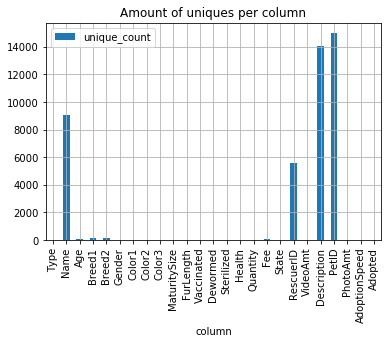

In [11]:
df_variables_info.plot.bar(x = 'column', y = 'unique_count', grid = True, title = 'Amount of uniques per column')

We can see that the columns **Name**, **Description**, **RescuerID** and **PetID** are the columns with **high cardinality**

**Bar Plot by nulls per column**

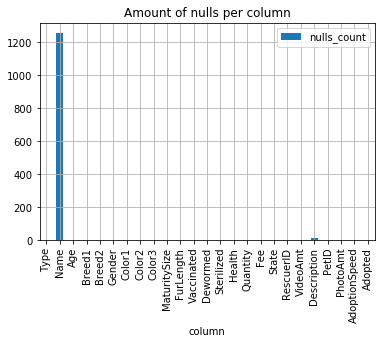

In [12]:
df_variables_info.plot.bar(x = 'column', y = 'nulls_count', grid = True, title = 'Amount of nulls per column')

We can see that just **two columns have null values: Name and Description**

**Bar plot by zeros per column**

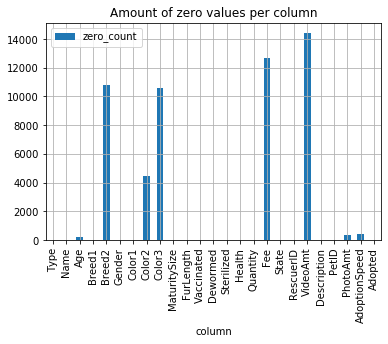

In [13]:
df_variables_info['zero_count'] = df_variables_info['zero_count'].replace('',0).astype(np.int64)
df_variables_info.plot.bar(x = 'column', y = 'zero_count', grid = True, title = 'Amount of zero values per column')

By analysing this graph, we can see some columns use zero values and after further analysis we see that **some columns probably use zero as null** 

**Plot by columns without referencial integrity**

Columns with referencial integrity

In [14]:
df_variables_info['without_ref_integrity_count'] = [s if s != '' else '0' for s in df_variables_info['without_ref_integrity_count']]
df_variables_info['without_ref_integrity_count'] = df_variables_info['without_ref_integrity_count'].astype(np.int64)
df_columns_without_ref_integrity = df_variables_info[df_variables_info['without_ref_integrity_count'] > 0] 
for index, row in df_columns_without_ref_integrity.iterrows():
  print('Column: {}; Nº of rows without referencial integrity: {}; Values: {}'.format(row['column'], row['without_ref_integrity_count'], row['without_ref_integrity_values']))

Column: Breed1; Nº of rows without referencial integrity: 5; Values: 0
Column: Breed2; Nº of rows without referencial integrity: 10762; Values: 0
Column: Color2; Nº of rows without referencial integrity: 4471; Values: 0
Column: Color3; Nº of rows without referencial integrity: 10604; Values: 0


We could see that the values without referencial integrity are always zero, which represent nulls for Breed and Color

Bar plot with all the columns

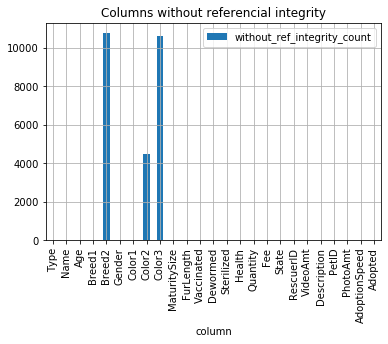

In [15]:
df_variables_info['without_ref_integrity_count'] = df_variables_info['without_ref_integrity_count'].replace('',0).astype(np.int64)
df_variables_info.plot.bar('column','without_ref_integrity_count', grid = True, title = 'Columns without referencial integrity')

By analysing these two graph we can conclude:

*   Breed1, Breed2, Color2 and Color3 have tuples without referencial integrity;
*   Breed1 and Breed2, use zero values to fill nulls, because there is no BreedID = 0 in breed_labels.csv;
*   Color2 and Color 3 use zero values to fill nulls, because there is no ColorID = 0 in color_labels.csv;
*   The columns Fee and Videoamt have a lot of zero values, but in that case dont seem to be null values because a pet may not have fee as well videos in its profile.

### Class Distribution

In this section we plot our target variables for classification taks, to check if we have a unbalanced dataset.

**Adopted**

'Adopted' was a featured that we created. It gives us the information if the animal was adopted. This will be **our target in binary classification task**.

Adopted = False if AdoptionSpeed = 4, otherwise Adopted = True.

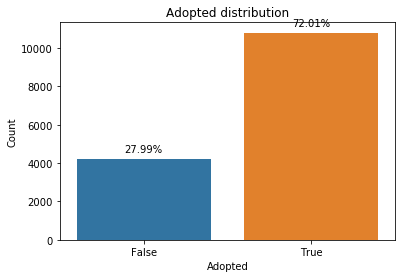

In [16]:
plot_class_destribution(df_main, 'Adopted')

We can see that in the dataset, only 28% of the data is categorized with Adopted = False. So we have an **unbalanced dataset**.

**Adoption Speed** 

Adoption Speed will be our target in multi classification task.

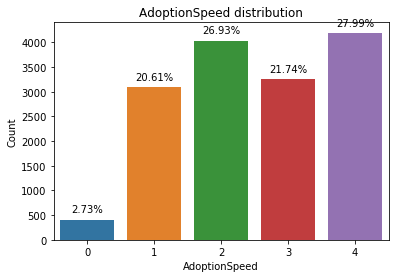

In [17]:
plot_class_destribution(df_main, 'AdoptionSpeed')

We can see that we have an **unbalanced dataset** for the classification of 'Adoption Speed'.

### Features Distribution

In this section we analysed the distribution of the different features, trying to recognise patterns and see how the data is distributed.

**Type**

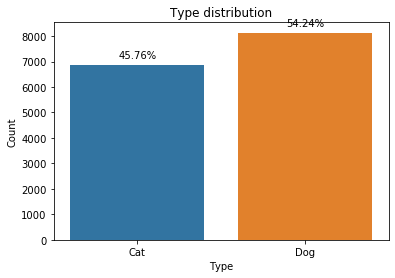

In [18]:
df_main_type = df_main.groupby(['Type']).size().to_frame('count').reset_index()
ax = sns_bar_plot('Type', 'count', df_main_type , ylabel = 'Count', title = 'Type distribution')
set_bar_percentage(ax, df_main)

We have an almost evenly distributed dataset in terms of Type (Dogs and Cats).

**Adoption Speed by Type**

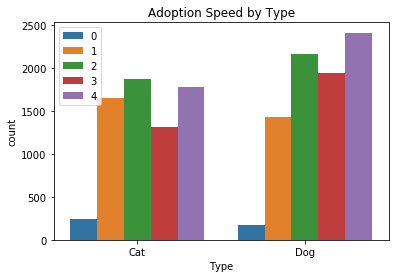

In [19]:
df_fee_free = df_main.groupby(['Type','AdoptionSpeed']).size().to_frame('count').reset_index()
ax = sns_bar_plot('Type', 'count', df_fee_free ,title = 'Adoption Speed by Type', hue="AdoptionSpeed")
plt.legend(loc='upper left')

In the plot above its difficult to get conclusions because we are comparing absolute values, and there are more Dogs than Cats.

We will use two pie charts to compare relative values

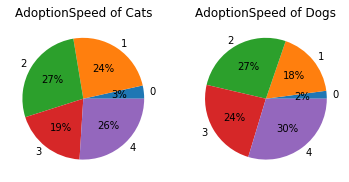

In [20]:
two_pie_charts(df_main,'Type', 'Cat', 'Dog','AdoptionSpeed', 'AdoptionSpeed of Cats', 'AdoptionSpeed of Dogs')

The main difference between the adoption speed of dogs/cats is that more dogs are not adopted. 30% of the dogs are not adopted vs 26% of the cats.

In adoption Speed = 0, which represents being adopted in the same day as it was listed, cats have +1% than dogs (3% vs 2%)

**Adopted by Type**

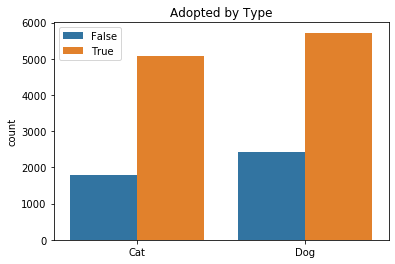

In [21]:
df_fee_free = df_main.groupby(['Type','Adopted']).size().to_frame('count').reset_index()
ax = sns_bar_plot('Type', 'count', df_fee_free , xlabel = '', title = 'Adopted by Type', hue="Adopted")
plt.legend(loc='upper left')

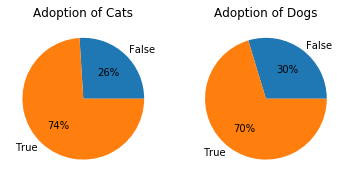

In [22]:
two_pie_charts(df_main,'Type', 'Cat', 'Dog','Adopted', 'Adoption of Cats', 'Adoption of Dogs')

The **cats have a higher probability of being adopted**, we can conclude. 74% of cats were adopted vs 70% of the dogs.

**Age**

Age basic statistics

In [23]:
df_main['Age'].describe()

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64

We can see that the mean Age is 10, but the max is 255. We will represent the Age distribution by grouping the DataFrame by Age and then count the number of records, but limiting the x axis to below 37

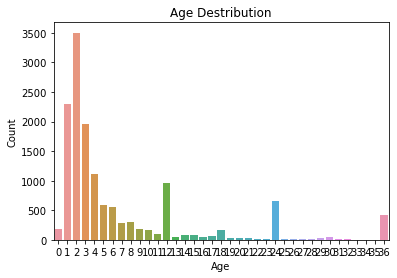

In [24]:
df_main_type = df_main.groupby(['Age']).size().to_frame('count').reset_index()
df_main_type = df_main_type[df_main_type['Age'] < 37]
ax = sns_bar_plot('Age', 'count', df_main_type , ylabel = 'Count', title = 'Age Destribution')

We can se that we have a lot of records with age = 2. Then it decreases, and we have higher bins in 12, 24 and 36 months, which represent 1, 2  and 3 years

**Fee**

Fee Distribution

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Fee Distribution <= 300')

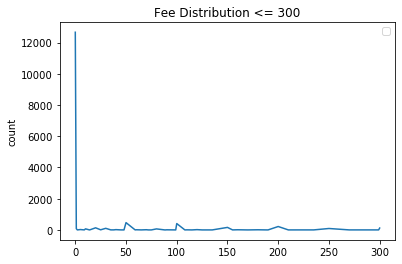

In [25]:
df_free = df_main.groupby(['Fee']).size().to_frame('count').reset_index()
df_free = df_free[df_free['Fee'] <= 300]
ax = sns.lineplot(x="Fee", y="count", data=df_free, markers = True)
plt.legend(loc='upper right')
ax.set_xlabel('')
ax.set_title('Fee Distribution <= 300')

We can see that **almost all of records in the dataset are free (fee =0)**, but besides that, we have some records with fee = 50,100,150, or 200.
We limit the plot to records where fee is less than 300, so that the plot is understandable

**Free/Not Free by Type**

We start by creating another column which identifies the pets that are free, meaning they have a fee = 0, and seeing the distribution in both types

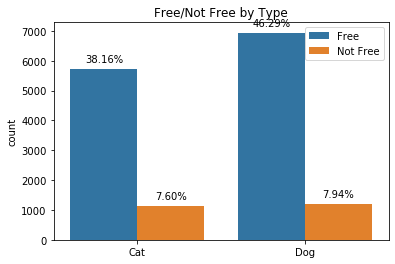

In [26]:
df_free = df_main.copy()
df_free['Free'] = ['Free' if v == 0 else 'Not Free' for v in df_free['Fee']]
df_plot = df_free.groupby(['Type','Free']).size().to_frame('count').reset_index()
ax = sns_bar_plot('Type', 'count', df_plot , xlabel = '', title = 'Free/Not Free by Type', hue="Free")
plt.legend(loc='upper right')
set_bar_percentage(ax, df_free)

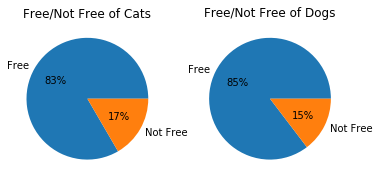

In [27]:
two_pie_charts(df_free,'Type', 'Cat', 'Dog','Free', 'Free/Not Free of Cats', 'Free/Not Free of Dogs')

By analysing the pie chart, we can see that **more Dogs are listed as free than Cats**: 85% of records about Dogs are Free vs 83% of the Cats.

**Adopted by Free / Not Free**

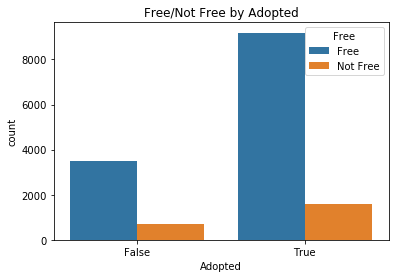

In [28]:
df_adopted_free = df_free.groupby(['Adopted','Free']).size().to_frame('count').reset_index()
ax = sns_bar_plot('Adopted', 'count', df_adopted_free , xlabel = 'Adopted', title = 'Free/Not Free by Adopted', hue="Free")

**Adoption Speed by Free / Not Free**

With this analysis we are trying to see if there is a relation between being listed as Free and being Adopted.

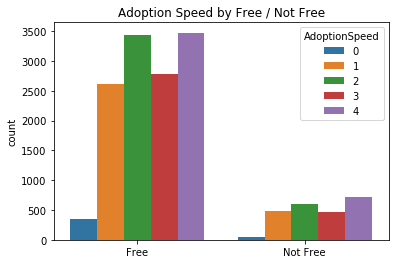

In [29]:
df_fee_free = df_free.groupby(['Free','AdoptionSpeed']).size().to_frame('count').reset_index()
ax = sns_bar_plot('Free', 'count', df_fee_free , xlabel = '', title = 'Adoption Speed by Free / Not Free', hue="AdoptionSpeed")

By comparing absolute values it doesn't give us much information, because most of the animals are listed as Free. We could normalize the data, but we decided to plot two pie charts to compare relative values.

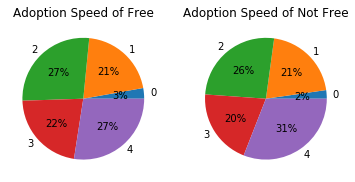

In [30]:
two_pie_charts(df_free, 'Free', 'Free', 'Not Free','AdoptionSpeed', 'Adoption Speed of Free', 'Adoption Speed of Not Free')

We can see that the 31% of the animals listed as Not Free are not adopted, vs 27% of the listed as Free. We can conclude that it **may exist a correlation between the two features**.

**Photo Amount**

Photo Amount Distribution

Text(0.5, 1.0, 'Photo Amount Distribution')

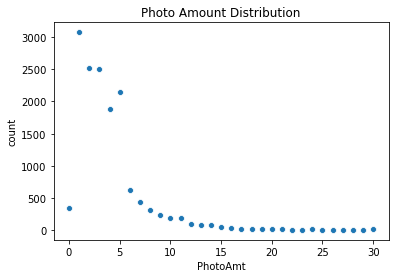

In [31]:
df_graph = df_main.groupby('PhotoAmt').size().to_frame('count').reset_index()
ax = sns.scatterplot(x='PhotoAmt', y = 'count', data = df_graph)
ax.set_title('Photo Amount Distribution')

We can see that most of records have less than 5 photos

Mean of phtos by Adoption Speed

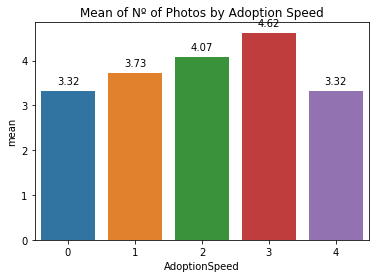

In [32]:
df_graph = df_main.groupby('AdoptionSpeed')['PhotoAmt'].describe().reset_index()
ax = sns_bar_plot('AdoptionSpeed', 'mean', df_graph, title = 'Mean of Nº of Photos by Adoption Speed')
set_bar_amount(ax)

We plot this because we were searching for a relation between the number of photos and Adoption Speed. We were testing the hypothesis if the animals that were not adopted did not have any photos. But it seems to be not the case.

Nº of Photos by Cats and Dogs

Text(0.5, 1.0, 'Plot line by number of photos by Type')

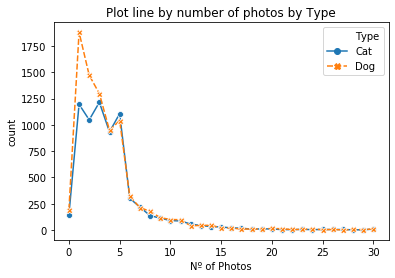

In [33]:
df_graph = df_main.groupby(['Type','PhotoAmt']).size().to_frame('count').reset_index()
ax = sns.lineplot(x="PhotoAmt", y="count", hue = "Type", style = 'Type',markers = True, data=df_graph)
ax.set_xlabel('Nº of Photos')
ax.set_title('Plot line by number of photos by Type')

Photo Amount by Adoption Speed

Text(0.5, 0, 'Nº of Photos')

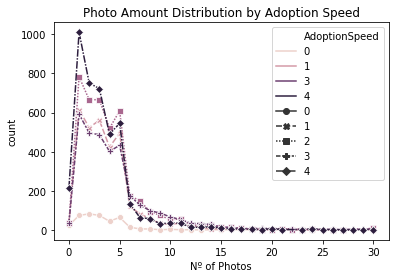

In [34]:
df_graph = df_main.groupby(['AdoptionSpeed','PhotoAmt']).size().to_frame('count').reset_index()
ax = sns.lineplot(x="PhotoAmt", y="count", hue = "AdoptionSpeed", style = 'AdoptionSpeed',markers = True, data=df_graph)
ax.set_title('Photo Amount Distribution by Adoption Speed')
ax.set_xlabel('Nº of Photos')

There are no big differences in the Nº of Photos Distribution beetween the differents Adoption Speed. The line that represents Adoption Speed = 0 is different because there are much less records for Adoption Speed = 0

Photo Amount by Adopted

Text(0.5, 0, 'Nº of Photos')

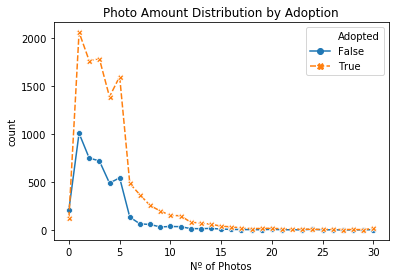

In [35]:
df_graph = df_main.groupby(['Adopted','PhotoAmt']).size().to_frame('count').reset_index()
ax = sns.lineplot(x="PhotoAmt", y="count", hue = "Adopted", style = 'Adopted',markers = True, data=df_graph)
ax.set_title('Photo Amount Distribution by Adoption')
ax.set_xlabel('Nº of Photos')

Generally, the adopted have more photos than the not adopted, comparing absolute values.

**Video Amount**

Video Amount Distribution

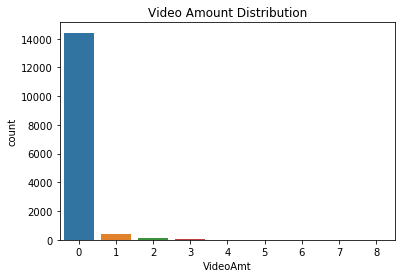

In [36]:
df_graph = df_main.groupby('VideoAmt').size().to_frame('count').reset_index()
ax = sns_bar_plot('VideoAmt', 'count', df_graph, title = 'Video Amount Distribution')

We can see that more than 14 000 records have Video Amount = 0, which means that having videos is not very common for pet profiles.

Video Amount by Type

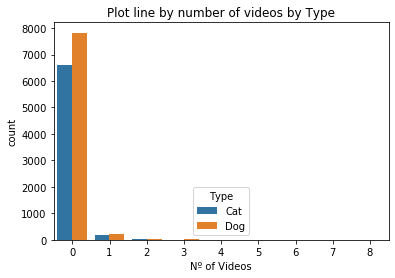

In [37]:
df_graph = df_main.groupby(['Type','VideoAmt']).size().to_frame('count').reset_index()
ax = sns_bar_plot('VideoAmt', 'count', df_graph,xlabel = 'Nº of Videos', title = 'Plot line by number of videos by Type', hue = "Type")

Video Amount by Adopted

Text(0.5, 0, 'Nº of Videos')

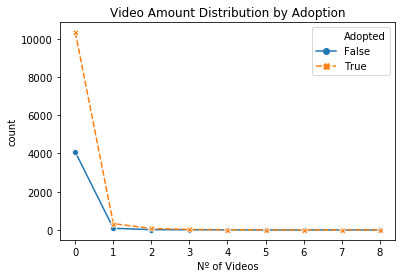

In [38]:
df_graph = df_main.groupby(['Adopted','VideoAmt']).size().to_frame('count').reset_index()
ax = sns.lineplot(x="VideoAmt", y="count", hue = "Adopted", style = 'Adopted',markers = True, data=df_graph)
ax.set_title('Video Amount Distribution by Adoption')
ax.set_xlabel('Nº of Videos')

**Description**

Length of Description

We start by creating a new column which maps the description by its length.

In [39]:
# Create a new feature which measures the size of the description
dfgus = df_main.copy()
dfgus['DescriptionLen'] = df_main['Description'].map(str).apply(len)
dfgus['DescriptionLen'].head()

0    359
1    118
2    393
3    146
4    390
Name: DescriptionLen, dtype: int64

We then see the distribution for each Adoption Speed to see if there is any difference in the size of their descriptions, but no observable difference is noted.

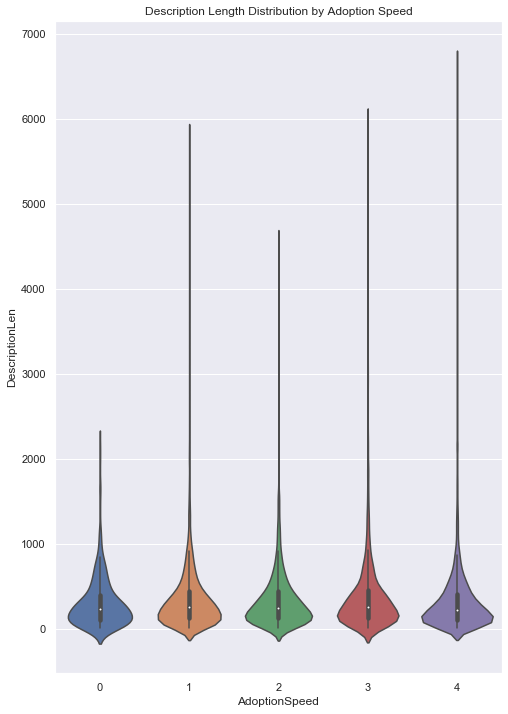

In [40]:
sns.set()
plt.figure(figsize = (8,12))
sns.violinplot(data = dfgus, x = "AdoptionSpeed", y = "DescriptionLen")
plt.title('Description Length Distribution by Adoption Speed')
plt.show()

**Breeds**


The analysis of breeds involved understanding if there was any breed that was more susceptible to being adopted with a certain speed or being adopted at all.

In [41]:
# Lets check breeds
# breeds go from 0 to 307 where 0 and 307 are null
# 266 is Domestic Short Hair Cat
# 265 is Domestic Medium Hair Cat
# In case we remove these Null and General breeds, do we have any famous breed?
dfgus.rename(columns={"Breed1":"BreedID"}, inplace = True)
dfgus2 = dfgus[~dfgus["BreedID"].isin([307,0,266,265])]

In [42]:
# Lets take out the breeds that occur less than 30 times
dfgus3 = dfgus2.groupby(["BreedID"]).AdoptionSpeed.count().reset_index()
dfgus3 = pd.DataFrame(dfgus3)

To carry out this analysis we only used breeds from Breed1 Column and with more than 50 examples.

In [43]:
dfgus4 = dfgus2.join(dfgus3.set_index('BreedID'), on='BreedID', lsuffix='_normal', rsuffix='_count')
dfgus4 = dfgus4[dfgus4['AdoptionSpeed_count'] > 50]
dfgus4 = dfgus4[(dfgus4['Breed2'] == dfgus4['BreedID']) | (dfgus4['Breed2'] == 0)]

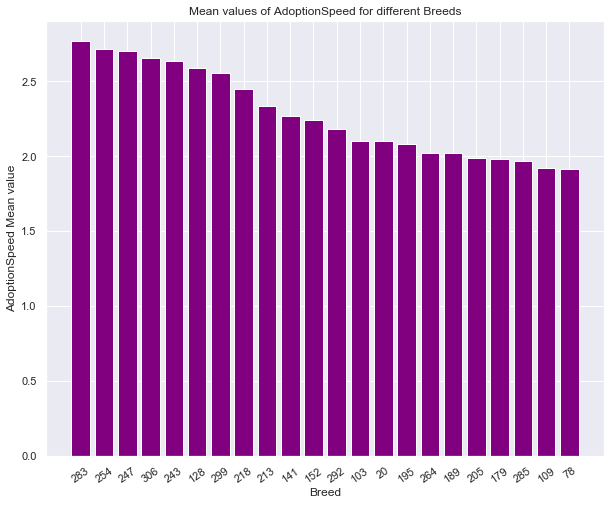

In [44]:
# The mean value for AdoptionSpeed according to the Breeds

databreeds = dfgus4.groupby(['BreedID']).AdoptionSpeed_normal.mean().sort_values(ascending = False).reset_index()
databreeds = pd.DataFrame(databreeds)
databreeds = databreeds.sort_values(["AdoptionSpeed_normal"], ascending = False).reset_index()
plt.figure(figsize=(10,8))
ax = plt.subplot()
plt.bar(range(len(databreeds['BreedID'])), databreeds['AdoptionSpeed_normal'], color = "purple")
ax.set_xticks(range(len(databreeds['BreedID'])))
ax.set_xticklabels(databreeds['BreedID'],rotation = 35)
plt.ylabel('AdoptionSpeed Mean value')
plt.xlabel('Breed')
plt.title('Mean values of AdoptionSpeed for different Breeds')
plt.show()

We first analysed the mean value of adoption speed for the filtered breeds to see if there was any major difference. Each number represents a Breed from the Breeds Dataset.

In [45]:
# To make it easier, we can see which breeds have the highest percentage for each AdoptionSpeed

databreedscounts = dfgus4.groupby(['BreedID','AdoptionSpeed_normal']).PetID.count().reset_index()
databreedstotals = dfgus4.groupby(['BreedID']).PetID.count().reset_index()
databreedscounts = pd.DataFrame(databreedscounts)
databreedstotals = pd.DataFrame(databreedstotals)
databreeds2 = databreedscounts.join(databreedstotals.set_index('BreedID'), on='BreedID', lsuffix='_1', rsuffix='_2')
databreeds2['percentage'] = databreeds2['PetID_1']/databreeds2['PetID_2']  # Number of Pets with that AdoptionSpeed / Number of Pets (for each breed)
databreeds3 = databreeds2.sort_values(['AdoptionSpeed_normal','percentage'], ascending = False)

In [46]:
breeds4 = databreeds3[databreeds3['AdoptionSpeed_normal'] == 4]
breeds3 = databreeds3[databreeds3['AdoptionSpeed_normal'] == 3]
breeds2 = databreeds3[databreeds3['AdoptionSpeed_normal'] == 2]
breeds1 = databreeds3[databreeds3['AdoptionSpeed_normal'] == 1]
breeds0 = databreeds3[databreeds3['AdoptionSpeed_normal'] == 0]

The plots below show the percentage that that specific breed has of the respective Adoption Speed.

So for example: First plot shows that on out dataset, breed number 306 has a 0.085% chance of being Adopted on the first day of posting, which is the highest. In comparison the red line shows the overall chance of a pet being adopted the same day, so all the bars above this line have a higher chance than normal and all below have a lower chance.

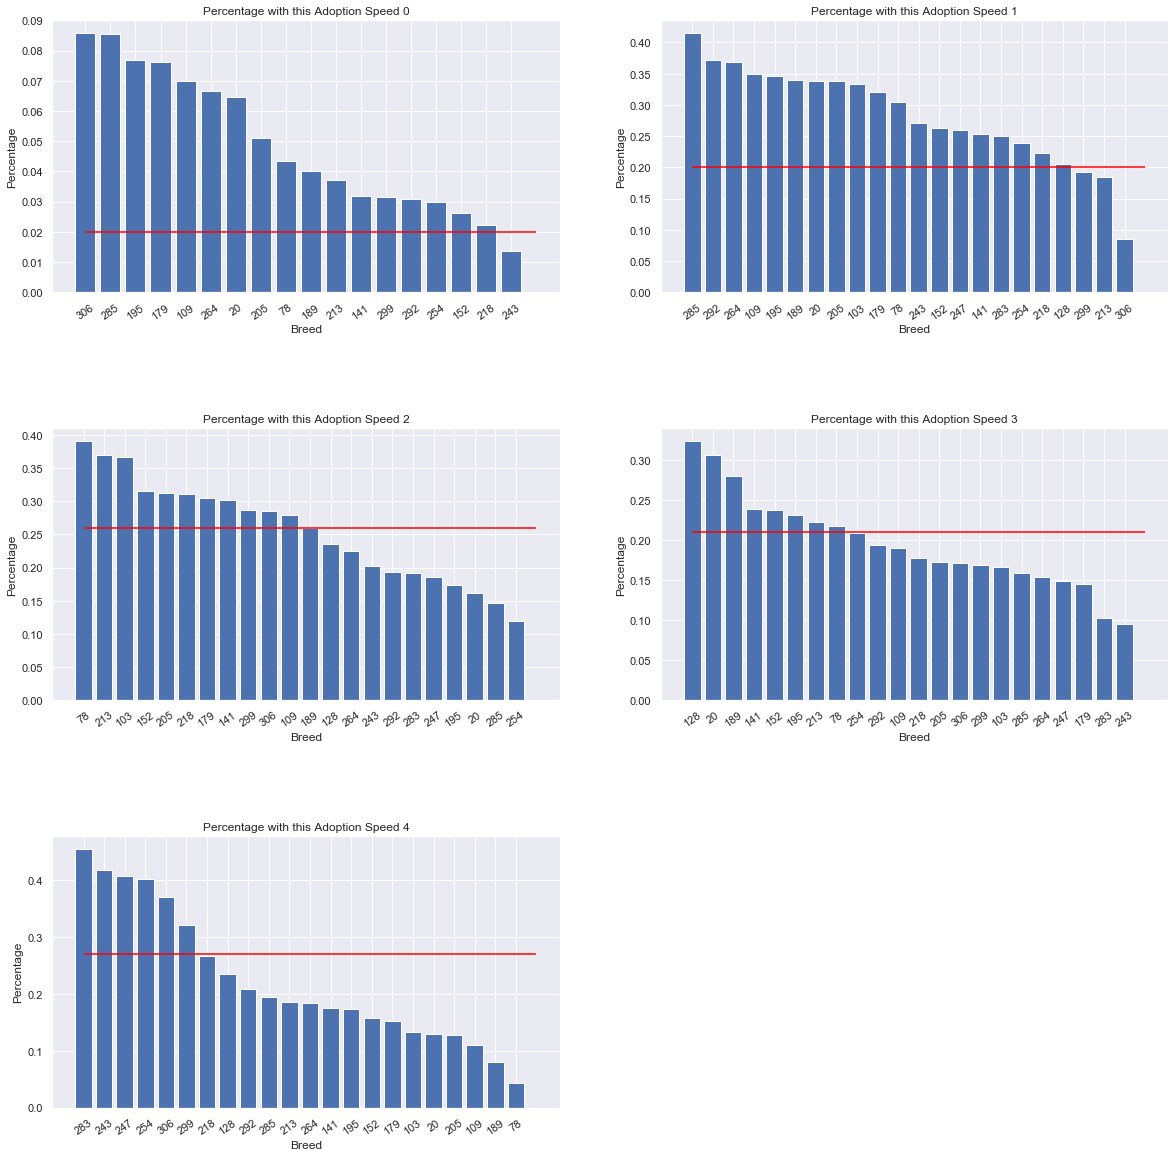

In [47]:
plt.figure(figsize=(20,20))
ax = plt.subplot(3,2,1)
plt.bar(range(len(breeds0['BreedID'])), breeds0['percentage'])
ax.set_xticks(range(len(breeds0['BreedID'])))
ax.set_xticklabels(breeds0['BreedID'],rotation = 35)
plt.ylabel('Percentage')
plt.xlabel('Breed')
plt.title('Percentage with this Adoption Speed 0')
plt.hlines(0.02,0,len(breeds0['BreedID']), colors="red")
ax = plt.subplot(3,2,2)
plt.bar(range(len(breeds1['BreedID'])), breeds1['percentage'])
ax.set_xticks(range(len(breeds1['BreedID'])))
ax.set_xticklabels(breeds1['BreedID'],rotation = 35)
plt.ylabel('Percentage')
plt.xlabel('Breed')
plt.title('Percentage with this Adoption Speed 1')
plt.hlines(0.2,0,len(breeds1['BreedID']), colors="red")
ax = plt.subplot(3,2,3)
plt.bar(range(len(breeds2['BreedID'])), breeds2['percentage'])
ax.set_xticks(range(len(breeds2['BreedID'])))
ax.set_xticklabels(breeds2['BreedID'],rotation = 35)
plt.ylabel('Percentage')
plt.xlabel('Breed')
plt.title('Percentage with this Adoption Speed 2')
plt.hlines(0.26,0,len(breeds2['BreedID']), colors="red")
ax = plt.subplot(3,2,4)
plt.bar(range(len(breeds3['BreedID'])), breeds3['percentage'])
ax.set_xticks(range(len(breeds3['BreedID'])))
ax.set_xticklabels(breeds3['BreedID'],rotation = 35)
plt.ylabel('Percentage')
plt.xlabel('Breed')
plt.title('Percentage with this Adoption Speed 3')
plt.hlines(0.21,0,len(breeds3['BreedID']), colors="red")
ax = plt.subplot(3,2,5)
plt.bar(range(len(breeds4['BreedID'])), breeds4['percentage'])
ax.set_xticks(range(len(breeds4['BreedID'])))
ax.set_xticklabels(breeds4['BreedID'],rotation = 35)
plt.ylabel('Percentage')
plt.xlabel('Breed')
plt.title('Percentage with this Adoption Speed 4')
plt.hlines(0.27,0,len(breeds4['BreedID']), colors="red")
plt.subplots_adjust(hspace=0.5)

plt.show()

In [48]:
breedsFalse = databreeds3[databreeds3['AdoptionSpeed_normal'] == 4]
beedsTrue = databreeds3[databreeds3['AdoptionSpeed_normal'] != 4]
beedsTrue2 = beedsTrue.groupby(['BreedID'])['percentage'].sum().reset_index()
breedsTrue = beedsTrue2.sort_values('percentage', ascending = False)

The same thing was done for the Binary Classification. In the first plot below, all breeds with bars above the red line, have a higher chance of **not being adopted**.

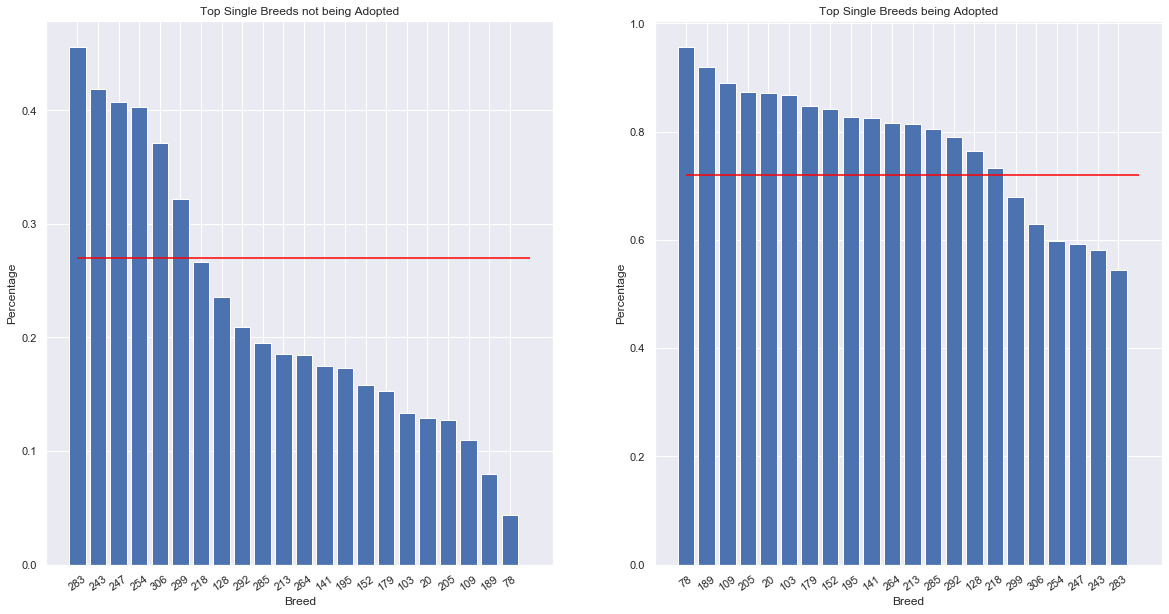

In [49]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,2,1)
plt.bar(range(len(breedsFalse['BreedID'])), breedsFalse['percentage'])
ax.set_xticks(range(len(breedsFalse['BreedID'])))
ax.set_xticklabels(breedsFalse['BreedID'],rotation = 35)
plt.ylabel('Percentage')
plt.xlabel('Breed')
plt.title('Top Single Breeds not being Adopted')
plt.hlines(0.27,0,len(breedsFalse['BreedID']), colors="red")
ax = plt.subplot(1,2,2)
plt.bar(range(len(breedsTrue['BreedID'])), breedsTrue['percentage'])
ax.set_xticks(range(len(breedsTrue['BreedID'])))
ax.set_xticklabels(breedsTrue['BreedID'],rotation = 35)
plt.ylabel('Percentage')
plt.xlabel('Breed')
plt.title('Top Single Breeds being Adopted')
plt.hlines(0.72,0,len(breeds1['BreedID']), colors="red")

**Colors**


An analysis was done on sets of colors from Color1 and Color2 to understand which sets were the most common and which were less when adopted and when not adopted. In the heatmap below we can see that color = 1 with color = 2 is the most common set for pets not being adopted.

In [50]:
pares = list(zip(df_main["Color1"][df_main["AdoptionSpeed"] == 4],df_main["Color2"][df_main["AdoptionSpeed"] == 4]))
colours = [0,1,2,3,4,5,6,7]
paresdict = {key:{key2:pares.count((key,key2)) for key2 in colours} for key in colours}
coloursdata = pd.DataFrame.from_dict(paresdict)

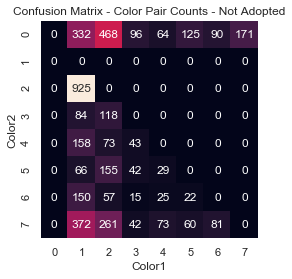

In [51]:
sns.heatmap(coloursdata, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Color1')
plt.ylabel('Color2');
plt.title('Confusion Matrix - Color Pair Counts - Not Adopted') 
plt.show()

In [52]:
pares = list(zip(df_main["Color1"][df_main["AdoptionSpeed"] != 4],df_main["Color2"][df_main["AdoptionSpeed"] != 4]))
colours = [0,1,2,3,4,5,6,7]
paresdict = {key:{key2:pares.count((key,key2)) for key2 in colours} for key in colours}
coloursdata = pd.DataFrame.from_dict(paresdict)

The following heatmap does the same analysis but for pets that were adopted. So we conclude from this observation that the Color Patterns for Color1 with Color2 do not vary for Adopted and Not Adopted pets. Color 3 is mostly constituted of 0s meaning no color, so it was ignored in this analysis.

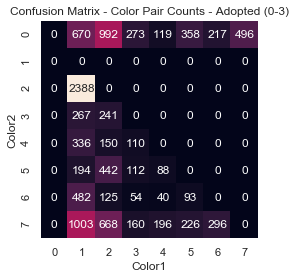

In [53]:
sns.heatmap(coloursdata, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Color1')
plt.ylabel('Color2');
plt.title('Confusion Matrix - Color Pair Counts - Adopted (0-3)') 
plt.show()

**Furlength**

For furlength a quick analysis was done to understand if there was any relation between the AdoptionSpeeds and the different categories of Furlength.

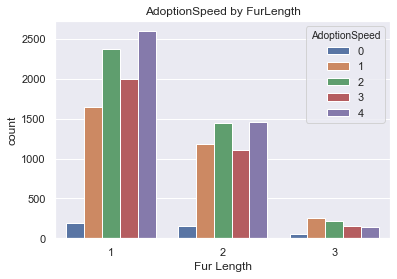

In [54]:
df_fur = df_main.groupby(['FurLength','AdoptionSpeed']).size().to_frame('count').reset_index()
ax = sns_bar_plot('FurLength', 'count', df_fur,xlabel = 'Fur Length', title = 'AdoptionSpeed by FurLength', hue = "AdoptionSpeed")

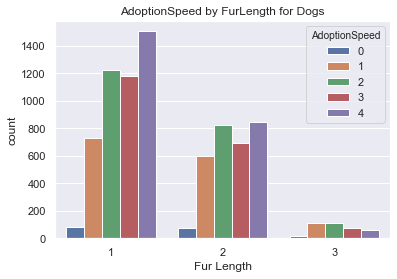

In [55]:
df_fur = df_main[df_main['Type']=='Dog'].groupby(['FurLength','AdoptionSpeed']).size().to_frame('count').reset_index()
ax = sns_bar_plot('FurLength', 'count', df_fur,xlabel = 'Fur Length', title = 'AdoptionSpeed by FurLength for Dogs', hue = "AdoptionSpeed")

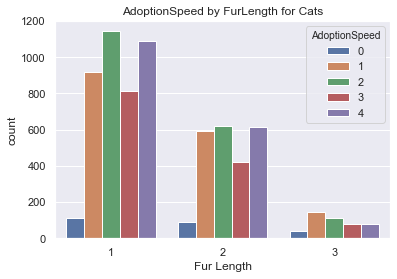

In [56]:
df_fur = df_main[df_main['Type']=='Cat'].groupby(['FurLength','AdoptionSpeed']).size().to_frame('count').reset_index()
ax = sns_bar_plot('FurLength', 'count', df_fur,xlabel = 'Fur Length', title = 'AdoptionSpeed by FurLength for Cats', hue = "AdoptionSpeed")

Fur Length 1 and 2 do not seem to show a different distribution in AdoptionSpeeds, while  Fur Length of 3 seems to have a higher chance of being adopted, even though the observations are much fewer than for the other categories.

**MaturitySize**

As it was done for Fur Length, Maturity Size was analysed for the different Adoption Speeds.

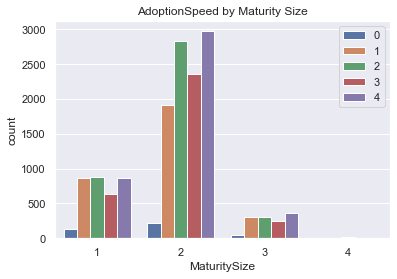

In [57]:
df_matur = df_main.groupby(['MaturitySize','AdoptionSpeed']).size().to_frame('count').reset_index()
ax = sns_bar_plot('MaturitySize', 'count', df_matur,xlabel = 'MaturitySize', title = 'AdoptionSpeed by Maturity Size', hue = "AdoptionSpeed")
plt.legend(loc='upper right')

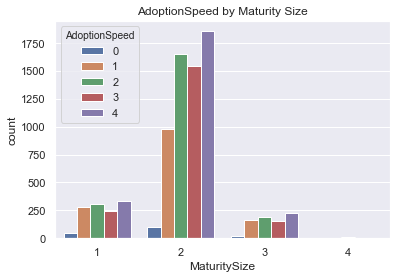

In [58]:
df_matur = df_main[df_main['Type']=='Dog'].groupby(['MaturitySize','AdoptionSpeed']).size().to_frame('count').reset_index()
ax = sns_bar_plot('MaturitySize', 'count', df_matur,xlabel = 'MaturitySize', title = 'AdoptionSpeed by Maturity Size', hue = "AdoptionSpeed")

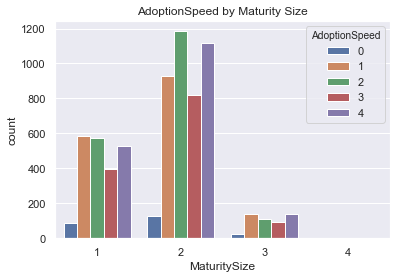

In [59]:
df_matur = df_main[df_main['Type']=='Cat'].groupby(['MaturitySize','AdoptionSpeed']).size().to_frame('count').reset_index()
ax = sns_bar_plot('MaturitySize', 'count', df_matur,xlabel = 'MaturitySize', title = 'AdoptionSpeed by Maturity Size', hue = "AdoptionSpeed")

On the contrary of Fur Length, Maturity Size does not seem to show any observable difference between the different MaturitySizes, and both 3 and especially 4 do not contain a good amount of cases to be able to take conclusions.

**Quantity**

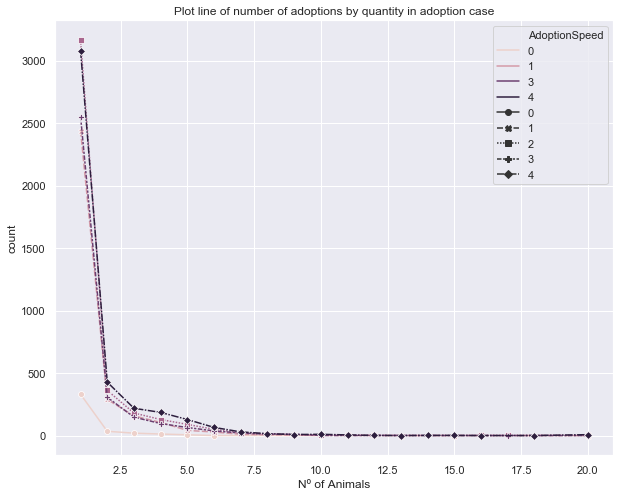

In [60]:
df_graph = df_main.groupby(['AdoptionSpeed','Quantity']).size().to_frame('count').reset_index()
plt.figure(figsize=(10,8))
ax = sns.lineplot(x="Quantity", y="count", hue = "AdoptionSpeed",style = "AdoptionSpeed", markers =True,  data=df_graph)
ax.set_xlabel('Nº of Animals')
ax.set_title('Plot line of number of adoptions by quantity in adoption case')
plt.show()

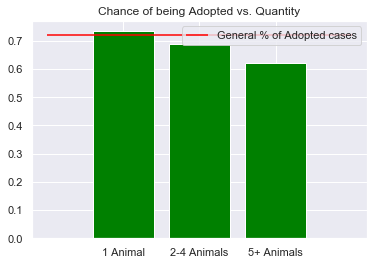

In [61]:
# First bin will be when it is just one animal and its probability of being Adopted

df_quantity1 = df_main[df_main['Quantity'] == 1]
df_quantity1adopted = df_main[(df_main['Quantity'] == 1) & (df_main['Adopted'] == True)]
y = list(range(3))
y[0] = df_quantity1adopted['Quantity'].count() / df_quantity1['Quantity'].count()  


# Second bin will be when it is 2-4 animals being adopted

df_quantity1 = df_main[df_main['Quantity'].isin([2,3,4])]
df_quantity1adopted = df_main[(df_main['Quantity'].isin([2,3,4])) & (df_main['Adopted'] == True)]
y[1] = df_quantity1adopted['Quantity'].count() / df_quantity1['Quantity'].count()  

# Third bin will be when it is 5+ animals being adopted

df_quantity1 = df_main[~df_main['Quantity'].isin([1,2,3,4])]
df_quantity1adopted = df_main[(~df_main['Quantity'].isin([1,2,3,4])) & (df_main['Adopted'] == True)]
y[2] = df_quantity1adopted['Quantity'].count() / df_quantity1['Quantity'].count() 

ax = plt.subplot()
plt.bar(list(range(len(y))), y, color = ['green'])
plt.hlines(0.72,-1,len(y), colors="red")
ax.set_xticks([0,1,2])
ax.set_xticklabels(['1 Animal', '2-4 Animals', '5+ Animals'])
plt.title('Chance of being Adopted vs. Quantity')
plt.legend(['General % of Adopted cases'])
plt.show()

Above we can see the distribution for quantity of animals in a pet profile, we were testing to see if profiles with multiple animals are less adopted.

With the help of the last bar plot we can clearly see that it is true - It categorizes the Quantity column in 3 sets and we see that having 5+ animals decreases the chance of Adoption.

# **Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed**

---

## Model Selection

In this section we will explain how we will select the best models for the classification task.

We will use two functions:

*    **best_model**: Uses GridSearchCV to find the best hyperparameters, and do resampling on each Training Set of Cross Validation iteration;
*    **feature_combinator**: Calls the best_model function, and tests different combinations of features.

The function **best_model**:

*   **Splits the data** into a training and validation set (90% and 10% size respectively);
*   **The training set will be used to train the model, and will be splited into train and test set** during each iteraction of cross validation;
*   **The validation set will be used to test the model**: this data will not be used to create the model, and will not be resampled;
*   **Create an imbalanced learn pipeline:** will execute the **resampling algorithm, in each cross validation iteration,** and then the learning algorithm, **only in the training set of each Cross Validation iteration**;
*   **Apply GridSearchCV** method that will search for the **best hyperparameters** of the learning algorithm;
*   Retrieve the x_test and y_test datasets, from outside of the function, and **tests the best model (that GridSearchCV finds) with the test set - that was not resampled, nor used to select the model**.

**Test the model with the x_test data set, that was not oversampled, is the best way to see if the chosen model (by GridSearchCV) generalizes well**

In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score

#based on: 
    #https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html;
    #https://towardsdatascience.com/imbalanced-class-sizes-and-classification-models-a-cautionary-tale-part-2-cf371500d1b3
    #https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn
    
def best_model(X, y, resampling_algorithm, learning_algorithm, params, kf):
    X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, y, random_state=45, test_size=0.1)
    
    #score metrics: multiclass classification dont allow avarege = 'binary' which is the default
    if len(np.unique(y)) == 2: precision_scorer = make_scorer(precision_score)
    #'micro':Calculate metrics globally by counting the total true positives, false negatives and false positives.
    else: precision_scorer = make_scorer(precision_score, average='micro')
    
    scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': precision_scorer}
    #!= False because: resampling_algorithm could assume two possible values: False or a method  
    if resampling_algorithm != False:
        #create imbalanced learn pipeline: execute resampling method in each CV iteration
        imba_pipeline = make_pipeline(resampling_algorithm(random_state=42), learning_algorithm())
        key_name = imba_pipeline.steps[1][0]
        new_params = {'{}__'.format(key_name) + key: params[key] for key in params}
        #GridSearchCV to search for the best hyperparameters
        grid = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring=scoring, refit='Accuracy', return_train_score = True).fit(X_train, y_train)
    else :
        grid = GridSearchCV(learning_algorithm(), param_grid = params, cv = kf, scoring = scoring, refit='Accuracy', return_train_score = True).fit(X_train, y_train)
    return X_test_validation, y_test_validation, grid

The function bellow, **feature_combinator**, will test **different combinations of features**. By default it will test all the possible combinations of 2, 3, 4 and 5 features, within the 'features' parameter.

This function calls the best_model function, for each possible combination of features. **This function will be used to find the best model of the different types of algorithms** that will be tested (Linears, Probablistics, etc...). For each model tested, it will save the records in a dataframe, called df_evaluation.

Pandas **DataFrame 'df_evaluation'** has the following columns:

1.  **Classifier**: Identifies the classifier;
2.  **best_HP**: The best hyperparameters that the GridSeachCV method (inside the best_model function) find;
3.  **Features**: Features used;
4.  **Accuracy**: Accuracy computed with the validation set;
5.  **Precision**: Precision computed with validation set;
6.  **Mean_CV_Train_Accuracy**: The mean calculated with the scores of the K Fold, with the training sets, inside the cross validation;
7.  **Mean_CV_Test_Accuracy**: The mean calculated with the scores of the K Fold, with the test sets, inside the cross validation;
8.  **AUC**: AUC computed with the validation set.

feature_combinator will return:


1.  Pandas Dataframe **df_evaluation**. This dataframe **will be converted into a CSV and saved in the results folder**;
2.  Best Accuracy Score found;
3.  **The best model found. This best model will be saved in the results folder, with the .sav extension, and then will be used to test with the Dog/Cat segmented data.**

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score
import warnings
warnings.filterwarnings('ignore')

def feature_combinator(df_X, df_y, features, resampling_algorithm, learning_algorithm, learning_params, kf, do_combinations = True, combinations_min_length = 2, combinations_max_length = 5):
    best_score_find = 0
    best_model_find = None
    #create dataframe with the classifier results
    df_evaluation = pd.DataFrame(columns=['Classifier', 'best_HP', 'Features','Accuracy','Precision','Mean_CV_Train_Accuracy','Mean_CV_Test_Accuracy','AUC'])
    if do_combinations == True:
        #maximum of 5 sized 
        for comb_len in range(combinations_min_length, combinations_max_length + 1):
            #foreach possible combination in 'features'
            for comb in combinations(features, comb_len):
                print("-------")
                print("Features: {}".format(list(comb)))

                X_test, y_test, grid = best_model(df_X[list(comb)], df_y.values, resampling_algorithm, learning_algorithm, learning_params , kf)

                model = grid.best_estimator_

                y_pred = model.predict(X_test)
                                    
                #AUC JUST IN BINARY CLASSIFICATION
                if len(np.unique(df_y.values)) == 2: 
                    roc_auc_score_validation_set = roc_auc_score(y_test, y_pred)
                    precision_score_validation_set = precision_score(y_test, y_pred)

                #IN MULTICLASSIFICATION PRINTS 0
                else: 
                    roc_auc_score_validation_set = 0
                    precision_score_validation_set = precision_score(y_test, y_pred, average = 'micro')
                
                accuracy_score_validation_set = accuracy_score(y_test, y_pred)
                
                #UPDATES THE BEST MODEL SCORE AND OBJECT
                if accuracy_score_validation_set > best_score_find:
                    best_score_find = accuracy_score_validation_set
                    best_model_find = model[1]
                row = {
                    'Classifier' : learning_algorithm.__name__,
                    'best_HP': grid.best_params_,
                    'Features':list(comb),
                    'Accuracy': accuracy_score_validation_set,
                    'Precision': precision_score_validation_set,
                    'Mean_CV_Train_Accuracy':grid.cv_results_['mean_train_Accuracy'].mean(),
                    'Mean_CV_Test_Accuracy':grid.cv_results_['mean_test_Accuracy'].mean(),
                    'AUC':roc_auc_score_validation_set
                }

                df_evaluation = df_evaluation.append(row, ignore_index = True)

                print("Best parameters: {}".format(grid.best_params_))
                print("AUC: {}".format(roc_auc_score_validation_set))
                print("Accuracy: {}".format(accuracy_score_validation_set))
                print('Precision: {}'.format(precision_score_validation_set))
                #print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_test_predict)))
                print(classification_report(y_test, y_pred))
                print("-------")

    else:
        for v in range(combinations_min_length, combinations_max_length + 1):
            comb =  list(df_feature_importances['column'])[0:v]
            print("-------")
            print("Top {} Features: {}".format(v, comb))

            X_test, y_test, grid = best_model(df_X[comb], df_y.values, resampling_algorithm, learning_algorithm, learning_params , kf)

            model = grid.best_estimator_

            y_pred = model.predict(X_test)

                        
            #AUC JUST IN BINARY CLASSIFICATION
            if len(np.unique(df_y.values)) == 2: 
                roc_auc_score_validation_set = roc_auc_score(y_test, y_pred)
                precision_score_validation_set = precision_score(y_test, y_pred)

            #IN MULTICLASSIFICATION PRINTS 0
            else: 
                roc_auc_score_validation_set = 0
                precision_score_validation_set = precision_score(y_test, y_pred, average = 'micro')
                
            accuracy_score_validation_set = accuracy_score(y_test, y_pred)
            
             #UPDATES THE BEST MODEL SCORE AND OBJECT
            if accuracy_score_validation_set > best_score_find:
                best_score_find = accuracy_score_validation_set
                best_model_find = model[1]

            row = {
                'Classifier' : learning_algorithm.__name__,
                'best_HP': grid.best_params_,
                'Features':comb,
                'Accuracy': accuracy_score_validation_set,
                'Precision': precision_score_validation_set,
                'Mean_CV_Train_Accuracy':grid.cv_results_['mean_train_Accuracy'].mean(),
                'Mean_CV_Test_Accuracy':grid.cv_results_['mean_test_Accuracy'].mean(),
                'AUC':roc_auc_score_validation_set
            }

            df_evaluation = df_evaluation.append(row, ignore_index = True)

            print("Best parameters: {}".format(grid.best_params_))
            print("AUC: {}".format(roc_auc_score_validation_set))
            print("Accuracy: {}".format(accuracy_score_validation_set))
            print('Precision: {}'.format(precision_score_validation_set))
            #print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_test_predict)))
            print(classification_report(y_test, y_pred))
            print("-------")
    df_evaluation = df_evaluation.sort_values('Accuracy', ascending=False).reset_index(drop=True)
    return df_evaluation, best_score_find, best_model_find

This function is used to get the data

In [64]:
def get_data(df, features=None, binary=False):
    if features is None: features = df.columns
    # guarantee that target features are not included
    features = remove_target_names(features)
    X = df[features]
    if binary == True:
            y = df[['Adopted']]
            target = 'Adopted'
    else:
        y = df[['AdoptionSpeed']]
        target = 'AdoptionSpeed'
    return X, y, features, target

def remove_target_names(df):
    '''Removes target features from vector of column names.'''
    if 'AdoptionSpeed' in df:
        df = df.drop('AdoptionSpeed')
    if 'Adopted' in df:
        df = df.drop('Adopted')
    return df

## Model Evaluation

In [65]:
##https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

For each model created we will evaluate:
*    Accuracy:
     1.   Mean Accuracy of Cross Validation in Training set;
     2.   Mean Accuracy of Cross Validation in Test set;
     3.   Accuracy on Validation Set.
*    Precision;
*    Area Under The Curve (On Binary Classification).

We will use **Accuracy** to select the best model.

## Preprocessing

In this section we will explain the techniques we used to Preprocess the data for classification:

1.   Feature Engineering;
2.   Data Standardization;
3.   Features encoding;
4.   Resampling.

###  Feature Engineering

Here we apply the Binning technique. The Binning method is used to divide the values of an attribute into bins or buckets. We will use this technique in two ways:

*   Pandas QCUT method: "Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles". from: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html;
*   Do a manual binary Binning: In some features, we will just create two bins. For example, in the feature 'Quantity', we will create one bin that saves all records with Quantity = 0, and other bins with Quantity != 0.

This techinique will be applied to the three dataframes used during the classification task:

*   df_main;
*   df_main_dogs: used in cats/dogs comparasion;
*   df_main_cats: used in cats/dogs comparasion.

**Age Categorical**

Here we change the Age attribute into 4 'equal-sized' bins:

*   0-2 months;
*   2-3 months;
*   3-12 months;
*   12 - * .

In [66]:
if feature_engineering == True: 
    df_main['Age'] = pd.qcut(df_main['Age'],4, duplicates='drop')
    df_main_cats['Age'] = pd.qcut(df_main_cats['Age'],4, duplicates='drop')
    df_main_dogs['Age'] = pd.qcut(df_main_dogs['Age'],4, duplicates='drop')
df_main['Age'].value_counts()

(-0.001, 2.0]    5986
(3.0, 12.0]      4259
(12.0, 255.0]    2782
(2.0, 3.0]       1966
Name: Age, dtype: int64

**Quantity Categorical**

For quantity feature we will create two bins: 1 animal per record or more than 1.

In [67]:
if feature_engineering == True: 
    df_main['Quantity'] = ['One' if int(q) == 1 else 'More than 1' for q in df_main['Quantity']]
    df_main_cats['Quantity'] = ['One' if int(q) == 1 else 'More than 1' for q in df_main_cats['Quantity']]
    df_main_dogs['Quantity'] = ['One' if int(q) == 1 else 'More than 1' for q in df_main_dogs['Quantity']]
df_main['Quantity'].value_counts()

One            11565
More than 1     3428
Name: Quantity, dtype: int64

**Fee Categorical**

For Fee feature we will create two bins too: 1 when fee = 0 and other where fee > 0

In [68]:
if feature_engineering == True: 
    df_main['Fee'] = [0 if f == 0 else 1 for f in df_main['Fee']]
    df_main_dogs['Fee'] = [0 if f == 0 else 1 for f in df_main_dogs['Fee']]
    df_main_cats['Fee'] = [0 if f == 0 else 1 for f in df_main_cats['Fee']]
    
df_main['Fee'].value_counts()

0    12663
1     2330
Name: Fee, dtype: int64

In the next 3 features (Dewormed, Vaccinated and Sterilized), we will create two bins: 1 for Yes and other for No/NotSure, by merging No and Not Sure values into a single bin.

**Dewormed Categorical**

In [69]:
if feature_engineering == True: 
    df_main['Dewormed'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main['Dewormed']]
    df_main_dogs['Dewormed'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main_dogs['Dewormed']]
    df_main_cats['Dewormed'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main_cats['Dewormed']]
df_main['Dewormed'].value_counts()

Yes            8397
No/Not Sure    6596
Name: Dewormed, dtype: int64

**Vaccinated Categorical**

In [70]:
if feature_engineering == True: 
    df_main['Vaccinated'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main['Vaccinated']]
    df_main_dogs['Vaccinated'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main_dogs['Vaccinated']]
    df_main_cats['Vaccinated'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main_cats['Vaccinated']]
df_main['Vaccinated'].value_counts()

No/Not Sure    9095
Yes            5898
Name: Vaccinated, dtype: int64

**Sterilized Categorical**

In [71]:
if feature_engineering == True: 
    df_main['Sterilized'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main['Sterilized']]
    df_main_dogs['Sterilized'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main_dogs['Sterilized']]
    df_main_cats['Sterilized'] = ['Yes' if int(f) == 1 else 'No/Not Sure' for f in df_main_cats['Sterilized']]

df_main['Sterilized'].value_counts()

No/Not Sure    11892
Yes             3101
Name: Sterilized, dtype: int64

**DescriptionLen Categorical**

Here we create a feature that saves the length of the Description feature.

Then we use pandas qcut function to create 10 equal-sized bins

In [72]:
if feature_engineering == True: 
    df_main['Description_len'] = df_main['Description'].map(str).apply(len)
    df_main['Description_len'] = pd.qcut(df_main['Description_len'], 10, duplicates='drop')

    df_main_dogs['Description_len'] = df_main_dogs['Description'].map(str).apply(len)
    df_main_dogs['Description_len'] = pd.qcut(df_main_dogs['Description_len'], 10, duplicates='drop')

    df_main_cats['Description_len'] = df_main_cats['Description'].map(str).apply(len)
    df_main_cats['Description_len'] = pd.qcut(df_main_cats['Description_len'], 10, duplicates='drop')
    
df_main['Description_len'].value_counts()

(0.999, 49.0]      1525
(137.0, 185.0]     1519
(380.0, 497.0]     1508
(716.0, 6664.0]    1498
(49.0, 95.0]       1498
(302.0, 380.0]     1493
(185.0, 238.0]     1493
(497.0, 716.0]     1490
(95.0, 137.0]      1487
(238.0, 302.0]     1482
Name: Description_len, dtype: int64

### Standardize data

Here we have a method to standardize the data (mean 0, var 1). **We will use it before doing PCA and SVM**

In [73]:
#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py
def standardize_data(df, features):
    return  pd.DataFrame(StandardScaler().fit_transform(df), columns= features)

### Features encoding

Here we define two **methods** that we will use during the notebook, to **encode categorical features**:


1.   int_encode_feature, that is used in **handling categorical features with two values**;
2.   ohenc_encode_feature,that uses **One Hot Encoding**, and it is used to **handle categorical features with more than two values**.

This is based in TP05 class

In [74]:
def int_encode_feature(vect):
    enc = LabelEncoder()
    label_encoder = enc.fit(vect)
    integer_classes = label_encoder.transform(label_encoder.classes_)
    t = label_encoder.transform(vect)
    return t

#ONE HOT ENCODER METHOD FROM TP05 CLASS

#For categorical features with more than two possible values, a different approach is used. 
#The idea is to encode each possible value as a distinct feature, using the so-called one-hot-encoding.

#We start by defining the function ohenc_encode_feature that given a target column (col), 
#the number of rows (nrow) and the number of possible values (ndim), replaces the original column by ndim new binary colums.
def ohenc_encode_feature(table_X, col, nrow, ndim, columns, column_to_encode):
    enc = LabelEncoder()
    label_encoder = enc.fit(table_X[:, col])
    integer_classes = label_encoder.transform(label_encoder.classes_).reshape(ndim, 1)
    enc = OneHotEncoder()
    one_hot_encoder = enc.fit(integer_classes)
    # First, convert feature values to 0-(N-1) integers using label_encoder
    num_of_rows = nrow
    t = label_encoder.transform(table_X[:, col]).reshape(num_of_rows, 1)
    # Second, create a sparse matrix with col columns, each one indicating
    # whether the instance belongs to the class
    new_features = one_hot_encoder.transform(t)
    new_features_names = enc.get_feature_names([column_to_encode])
    columns.remove(column_to_encode)
    columns.extend(new_features_names)
    # Add the new features to table_X
    table_X = np.concatenate([table_X, new_features.toarray()], axis = 1)
    # Eliminate converted columns
    table_X = np.delete(table_X, [col], 1)
    return new_features_names,  pd.DataFrame(table_X, columns= columns)

Here we define some generic functions that will be used during the notebook, to encode a bunch of features

In [75]:
def binary_encode_columns(df, cols):
    for c in cols:
        column_index = df.columns.get_loc(c)
        df[c] = int_encode_feature(df[c].values)
        df[c] = df[c].astype(float)
    return df

def one_hot_encoding_columns(df, cols_to_encode):
    columns = list(df)
    num_of_rows = len(df)
    for c in cols_to_encode:
        column_index = df.columns.get_loc(c)
        num_uniques = len(list(df[c].unique()))
        new_columns_names, df = ohenc_encode_feature(df.values, column_index, num_of_rows, num_uniques, columns, c)
        df[new_columns_names] = df[new_columns_names].astype(float)
    return df

Here we define the columns that we want to do binary or onehotencoding.

Quantity, Fee, Dewormed, Vaccinated and Sterilized have to be binary encoded because **we created two bins**, for each column, in section 3.3.1

In [76]:
binary_encode_columns_encode = ['Type','Fee','Quantity','Dewormed','Vaccinated','Sterilized']
onehot_encode_columns = ['Gender','MaturitySize','FurLength','Age','Description_len']

### Resampling

As we can see in point 2.3.2 we have an **unbalanced class distribution**. For our binary classification task we have one class with += 28% of records (Not Adopted) and 72% of the record with Adopted. For our multiclassification task we have the class 0 that have less than 3% of the records.

We will do a **Principal Component Analysis (PCA)** to reduce the number of variables to 2 Components, so we can **represent our dataset in a 2D space**, **to check the differences before and after applying resampling techniques**.

Here we define functions that we used to apply PCA

In [77]:
#PRINCIPAL COMPONENT ANALYSIS, REDUCE THE NUMBER OF VARIABLES TO NUM_COMPONENTS
def pca(df):
    principalComponents = PCA(n_components = 2)
    principalComponents = principalComponents.fit_transform(df)
    return pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
def plot_pca_2d(df, title,target_variable):   
    fig = plt.figure(figsize = (14,14))
    plt.ylim(-8,8)
    plt.xlim(-8,8)
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    
    targets = list(df[target_variable].unique())
    targets.sort()
    
    colors_multi = {'0':'r', '1':'b', '2':'g', '3':'yellow', '4':'black'}
    color_binary = {'True':'r', 'False':'b'}
    
    for target in targets:
        if len(targets) > 2: color = colors_multi[str(target)]
        else: color = color_binary[str(target)]
        indicesToKeep = df[target_variable] == target
        ax.scatter(df.loc[indicesToKeep, 'principal component 1']
                , df.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 8)
    ax.legend(targets)
    ax.grid(True)

#### Binary classification

In this section we will:

1. Apply PCA to our dataset and plot it with a scatter plot;
2. Apply the SMOTE oversampling algorithm, and PCA before plotting the data with a scatter plot.

Scatter plot our dataset **with unbalanced data**, with 2 labels: binary classification

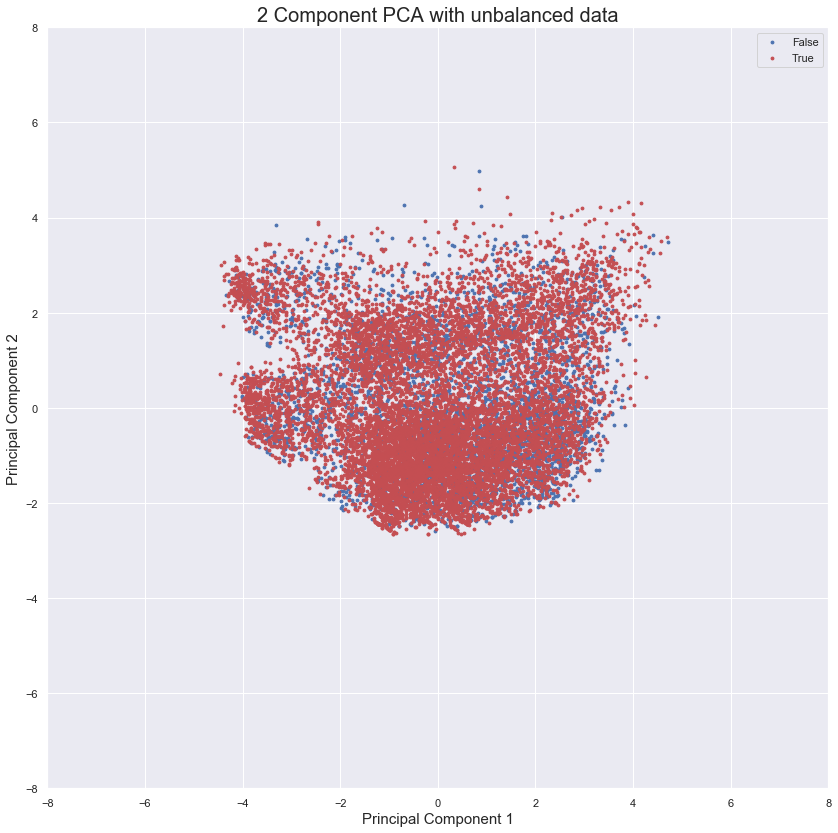

In [78]:
columns_to_remove = ['Description','Name','RescuerID','PetID']
df_X, df_y, features, target = get_data(df_main, df_main.columns[~df_main.columns.isin(columns_to_remove)], True)

#BINARY ENCODING
df_X = binary_encode_columns(df_X, binary_encode_columns_encode)
#ONE HOT ENCODING
df_X = one_hot_encoding_columns(df_X, onehot_encode_columns)

#STANDARDIZE DATA BEFORE PCA
df_X = standardize_data(df_X, df_X.columns)

X_pca = pca(df_X)
df_X_pca = pd.concat([X_pca, df_y], axis = 1)
plot_pca_2d(df_X_pca, '2 Component PCA with unbalanced data',target)

For **the binary classification task**, we decided to use the **SMOTE oversampling method**. IT will generate random data, based on euclidean distances between other existing data, this will be done only for our minority class.

We will apply the SMOTE method, and then we will plot the 2D scaled data, as for our binary class distribution

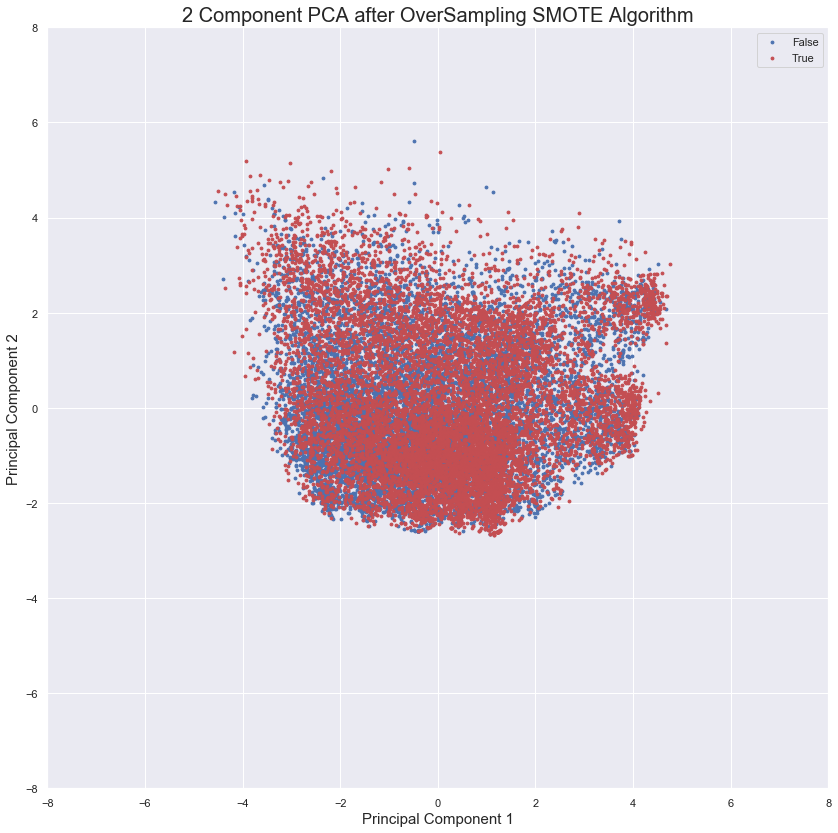

In [79]:
columns_to_remove = ['Description','Name','RescuerID','PetID']
df_X, df_y, features, target = get_data(df_main, df_main.columns[~df_main.columns.isin(columns_to_remove)], True)

#BINARY ENCODING
df_X = binary_encode_columns(df_X, binary_encode_columns_encode)
#ONE HOT ENCODING
df_X = one_hot_encoding_columns(df_X, onehot_encode_columns)

#APPLY SMOTE OVERSAMPLING ALGORITHM
X_sm, y_sm = SMOTE().fit_sample(df_X.values, df_y.values)
df_X = pd.DataFrame(X_sm, columns= df_X.columns)

#STANDARDIZE DATA BEFORE PCA
df_X = standardize_data(df_X, df_X.columns)

df_X_pca = pca(df_X)
df_X_pca[target] = y_sm

plot_pca_2d(df_X_pca, '2 Component PCA after OverSampling SMOTE Algorithm', target)

We can see that after applying the SMOTE algorithm, **we have a lot more blue points**: Adopted = False (As was intended)

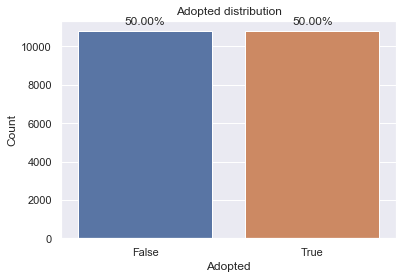

In [80]:
plot_class_destribution(df_X_pca,target)

We can see that **after applying the SMOTE oversampling algorithm we have our dataset balanced.**

#### Multiclass classification

**Scatter plot our unbalanced dataset for multiclass classification task, after aplying PCA**, with 5 labels: Multiclass Classification

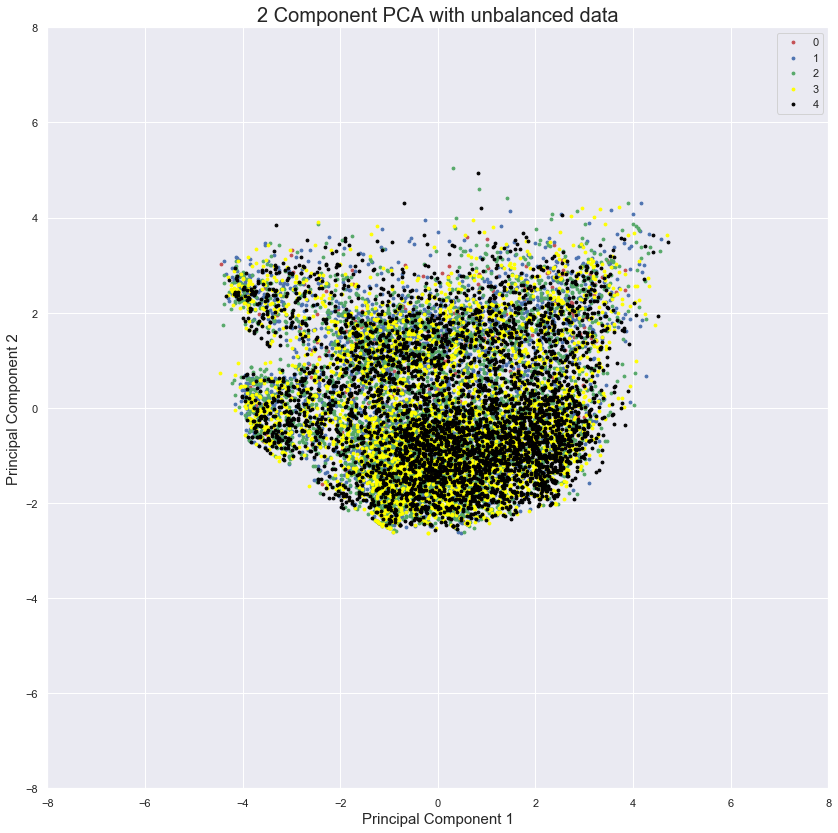

In [81]:
columns_to_remove = ['Description','Name','RescuerID','PetID']
df_X, df_y, features, target = get_data(df_main, df_main.columns[~df_main.columns.isin(columns_to_remove)], False)

#BINARY ENCODING
df_X = binary_encode_columns(df_X, binary_encode_columns_encode)
#ONE HOT ENCODING
df_X = one_hot_encoding_columns(df_X, onehot_encode_columns)

#STANDARDIZE DATA BEFORE PCA
df_X = standardize_data(df_X, df_X.columns)

X_pca = pca(df_X)
df_X_pca = pd.concat([X_pca, df_y], axis = 1)
plot_pca_2d(df_X_pca, '2 Component PCA with unbalanced data',target)

For our **Multiclass Classification task**, we decided to use **SMOTETomek resampling algorithm**. 

"Tomek links remove unwanted overlap between classes where majority class links are removed until all minimally distanced nearest neighbor pairs are of the same class" from : https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#Tomek_links

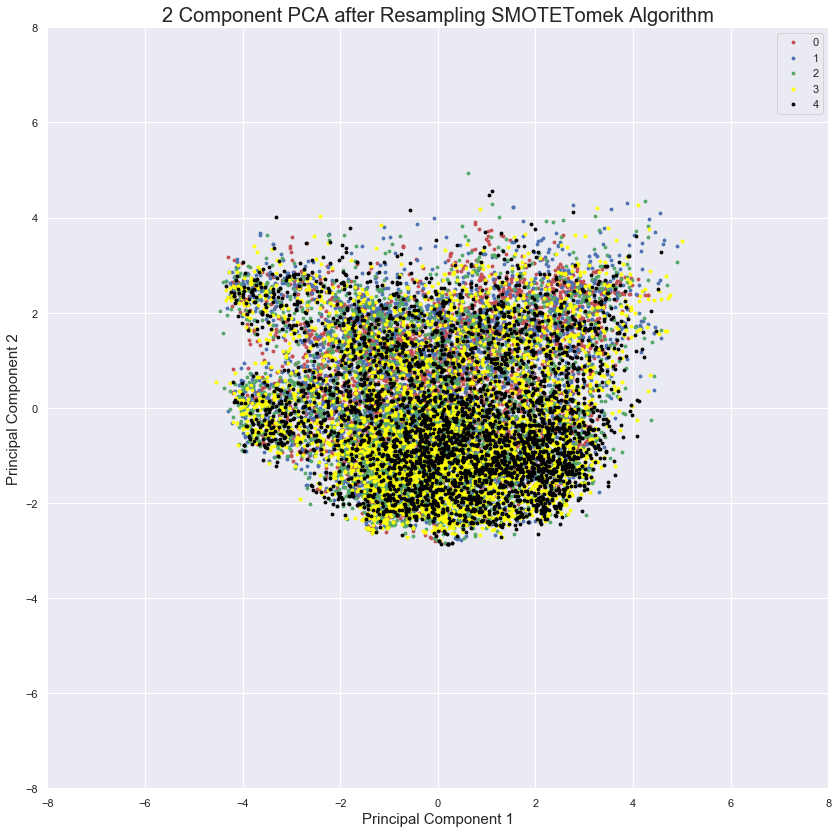

In [82]:
columns_to_remove = ['Description','Name','RescuerID','PetID']
df_X, df_y, features, target = get_data(df_main, df_main.columns[~df_main.columns.isin(columns_to_remove)], False)

#BINARY ENCODING
df_X = binary_encode_columns(df_X, binary_encode_columns_encode)
#ONE HOT ENCODING
df_X = one_hot_encoding_columns(df_X, onehot_encode_columns)

#APPLY SMOTE OVERSAMPLING ALGORITHM
X_sm, y_sm = SMOTETomek().fit_sample(df_X.values, df_y.values)
df_X = pd.DataFrame(X_sm, columns= df_X.columns)

#STANDARDIZE DATA BEFORE PCA
df_X = standardize_data(df_X, df_X.columns)

df_X_pca = pca(df_X)
df_X_pca[target] = y_sm

plot_pca_2d(df_X_pca, '2 Component PCA after Resampling SMOTETomek Algorithm', target)

After applying the SMOTETomek resampling technique we can see that we have **a lot more red points** (class 0).

We will plot our multiclass distribution in a bar chart

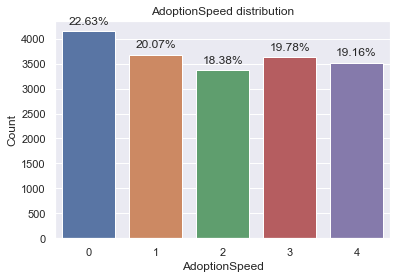

In [83]:
plot_class_destribution(df_X_pca,target)

We can see that, compared to our distribution before applying the SmoteTomek algorithm, **now almost 23% of our values are from class 0**.

### Feature Selection

**As the number of features increases, the model becomes more complex. The more the number of features, the more the chances of overfitting.** A machine learning model that is trained on a large number of features, gets increasingly dependent on the data it was trained on and in turn becomes overfitted, resulting in poor performance on real data, beating its purpose.


#### Dimensionality Reduction

Dimensionality reduction is the process of reducing the dimension of the feature set.

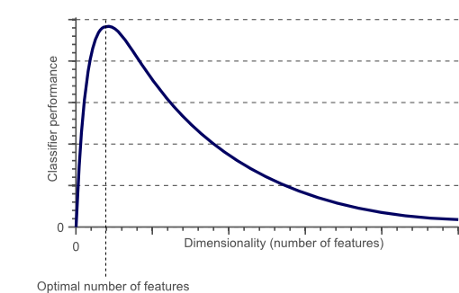

"Avoiding overfitting is a major motivation for performing dimensionality reduction. **The fewer features our training data has, the lesser assumptions our model makes** and the simpler it will be." (from https://towardsdatascience.com/dimensionality-reduction-for-machine-learning-80a46c2ebb7e)

In the cell below we will get the data to use in the following section

In [84]:
#GET DATA
df_X, df_y, features, target = get_data(df_main, df_main.columns, True)

#BINARY ENCODING
df_X = binary_encode_columns(df_X, binary_encode_columns_encode)
#ONE HOT ENCODING
df_X = one_hot_encoding_columns(df_X, onehot_encode_columns)

#### Random Forest

In this section we will create a **Random Forest** for **feature selection**

We start by defining a list that saves the **columns that we dont want to give to the Random Forest**. Adopted and AdoptionSpeed because they are the **target variables**, and RescuerID and PetID because they are the **unique identifiers** and work more as metadata for each observation.

Because Tree Models tend to bias unique columns, **we will not use Description and Name** features in our models due to their high cardinality

In [85]:
columns_to_remove = ['Description','Name','RescuerID','PetID','Adopted','AdoptionSpeed']
df_X_rf = df_X[df_X.columns[~df_X.columns.isin(columns_to_remove)]].copy()

Now we will use our best_model function, that will:

1. Use GridSearchCV to search for the best hyperparameters (gini index or entropy as split criterion);
2. 5 Fold Cross validation;
3. **Inside each iteration of CV, will be used a imblearn pipeline that will apply the SMOTE oversampling algorithm just to the training set, so that the test data is not biased with the resampled data.**
4. We will test the best model returned with the X_test data, that is not biased, and print the Accuracy Score and Confusion Matrix.
5. Plot the features_importances of the Random Forest, to check for the most important features.

Accuracy on validation set: 0.7353333333333333
Confusion on validation set: [[162 283]
 [114 941]]
Mean Train Accuracy: 0.9978970621920142
Mean Test Accuracy: 0.7447194428049155


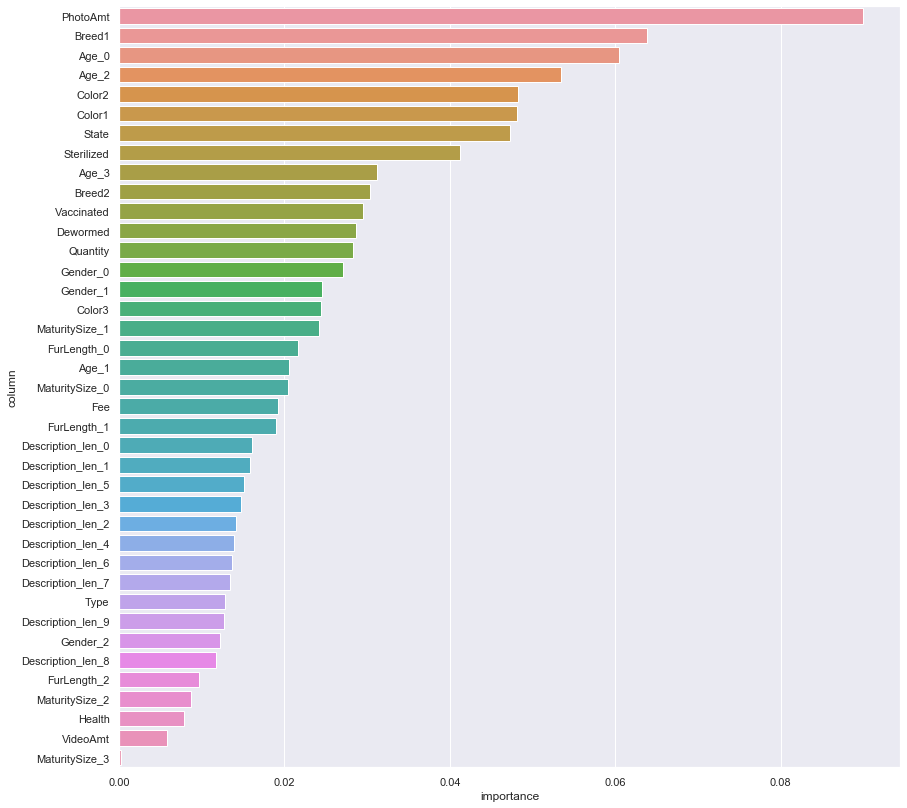

In [86]:
params = {'criterion':['gini','entropy']}
kf_5 = 5
X_test, y_test, grid = best_model(df_X_rf, df_y.values, SMOTE, RandomForestClassifier,params, kf_5)
#BEST RF
model = grid.best_estimator_[1]
#CREATE DataFrame TO PLOT THE DATA
df_feature_importances = pd.DataFrame(model.feature_importances_, index = df_X_rf.columns,
                                    columns=['importance']).sort_values('importance',ascending=False).reset_index().rename(columns={'index':'column'}) 

y_pred = model.predict(X_test)

print('Accuracy on validation set: {}'.format(accuracy_score(y_test, y_pred))) 
print('Confusion on validation set: {}'.format(confusion_matrix(y_test, y_pred)))

print('Mean Train Accuracy: {}'.format(grid.cv_results_['mean_train_Accuracy'].mean()))
print('Mean Test Accuracy: {}'.format(grid.cv_results_['mean_test_Accuracy'].mean()))

#PLOT IT
plt.figure(figsize=(14,14))
sns.barplot(x= 'importance', y = 'column', data = df_feature_importances)


According to the Random Forest these are the most relevant features for our models and will be used in future sections.

## **Binary Classification Task: Predict Adopted**

We start by getting the Data to give to the models for training. 

In [87]:
# GET DATA
df_X, df_y, features, target = get_data(df_main, df_main.columns, True)
#ENCODE THE TARGET COLUMN : Adopted
df_y = binary_encode_columns(df_y, ['Adopted'])
#BINARY ENCODING
df_X = binary_encode_columns(df_X, binary_encode_columns_encode)
#ONE HOT ENCODING
df_X = one_hot_encoding_columns(df_X, onehot_encode_columns)

Then we get the 7 more important features, according to the Random Forest, and then we filter the dataset according to those features.

In [88]:
more_important_columns = list(df_feature_importances.loc[0:7]['column'])
df_X = df_X[df_X.columns[df_X.columns.isin(more_important_columns)]].copy()

### Tree Models (Decision Tree)

This boolean controls if the will run the code to search for the best Decision Tree, or if we will load the results and the best model from the results folder

**Because models take time to train, this boolean will be = False during the project, and the results will be loaded from the 'results' folder**.

In [89]:
run_dt = False

In this section we will train a **bunch of combinations of Decision Tree models to see which works better**:


*   We will use OverSampling SMOTE algorithm, to oversample the minority class;
*   5 Fold cross validation;
*   Two Different split criterions (entropy or gini-index);
*   All possible combination of features,between 2 and 5, within the top 7 features of the random forest;
*   The results will be saved in a CSV;
*   The best model finded will be saved as a .sav file.


First we ensure that the folder where the data will be saved exists

In [90]:
#create folder to save binary decision tree results
results_binary_dt_folder = '{}/decision_tree'.format(results_binary_folder)
Path(results_binary_dt_folder).mkdir(parents=True, exist_ok=True)

Now we define the hyper params to search for, and search for our best model, by calling our feature_combinator function

In [91]:
if run_dt == True:
    params = {'criterion': ['entropy','gini']}
    kf_5 = KFold(n_splits=5, random_state=42, shuffle=False)
    df_evaluation_dt, best_score_find, best_model_find = feature_combinator(df_X, df_y, df_X.columns,SMOTE,tree.DecisionTreeClassifier, params,kf_5, True)

Now we save our best model as a .sav file and convert the dataframe df_evaluation_dt to a csv. Both files are saved in /data/binary/decision_tree

In [92]:
if run_dt == True:
    
    #SAVE BEST MODEL TO DIRECTORY
    best_model_name = 'best_model.sav'
    pickle.dump(best_model_find, open('{}/{}'.format(results_binary_dt_folder,best_model_name), 'wb'))
    
    #SAVE DATAFRAME RESULTS TO CSV
    dt_binary_evaluation_csv_path = '{}/df_evaluation_dt.csv'.format(results_binary_dt_folder)
    df_evaluation_dt.to_csv(dt_binary_evaluation_csv_path, sep = ';', index = False)
    
else: df_evaluation_dt = pd.read_csv('{}/{}'.format(results_binary_dt_folder, 'df_evaluation_dt.csv'), sep = ';') 

In [93]:
df_evaluation_dt

,Classifier,best_HP,Features,Accuracy,Precision,Mean_CV_Train_Accuracy,Mean_CV_Test_Accuracy,AUC
0,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'gini'},"['Breed1', 'Sterilized', 'Age_2']",0.688000,0.786341,0.697491,0.683688,0.635923
1,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Breed1', 'Sterilized', 'State']",0.686000,0.780769,0.690209,0.657045,0.628654
2,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Color1', 'Sterilized']",0.680667,0.743243,0.685985,0.685986,0.575489
3,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Color2', 'Sterilized']",0.680667,0.743243,0.673479,0.671312,0.575489
4,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Breed1', 'Color1', 'Sterilized', 'Age_2']",0.676667,0.783865,0.717057,0.679426,0.629166
...,...,...,...,...,...,...,...,...
205,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'gini'},"['Color1', 'PhotoAmt']",0.520667,0.744898,0.535352,0.519752,0.545551
206,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'gini'},"['Breed1', 'Color1', 'Color2']",0.520667,0.777228,0.553657,0.511304,0.571537
207,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'gini'},"['Breed1', 'Color1']",0.514000,0.781034,0.535074,0.513265,0.571995
208,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'gini'},"['Color2', 'PhotoAmt']",0.506667,0.740458,0.529367,0.513378,0.538847


The best decision tree finded have:

1.  Split criterion: Gini Index;
2.  Features used: Breed1, Sterilized and Age_2;

### Linear Models (SVM)

This boolean controls if the will run the code to search for the best SVM, or if we will load the results

In [94]:
run_svm = False

In this section we will train a **bunch of combinations of Support Vector Machines to see which works better**:


*   We will use OverSampling SMOTE algorithm, to oversample the minority class;
*   5 Fold cross validation;
*   Different combinations of 'gamma' and 'C' hyperparameters;
*   All possible combination of features,between 3 and 5, within the top 5 features of the random forest;
*   The results will be saved in a CSV;
*   The best model finded will be saved as a .sav file.

In [95]:
#create folder to save binary svm results
results_binary_svm_folder = '{}/svm'.format(results_binary_folder)
Path(results_binary_svm_folder).mkdir(parents=True, exist_ok=True)

Because SMV's take to long to train, **we will only create SVM models with the top 5 features**, according to the Random Forest

In [96]:
more_important_columns = list(df_feature_importances.loc[0:5]['column'])
df_X_svm = df_X[df_X.columns[df_X.columns.isin(more_important_columns)]].copy()

**Because SVM's are very sensitive to the scale of the data, we standardize our data prior to model training**

In [97]:
df_X_svm_cc = df_X_svm.copy()
df_X_svm_cc = standardize_data(df_X_svm_cc, df_X_svm_cc.columns)

We will create train different SVM models, with different hyper parameters, and save it in df_evaluation_svm DataFrame

In [98]:
if run_svm == True:

    #different hyper parameters to train
    params = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100]}
    kf_5 = KFold(n_splits=5, random_state=42, shuffle=False)
    df_evaluation_svm, best_score, best_model_find = feature_combinator(df_X_svm_cc, df_y, df_X_svm_cc.columns, SMOTE, SVC, params, kf_5, True, 3, 5)
    
    #SAVE BEST MODEL TO DIRECTORY
    best_model_name = 'best_model.sav'
    pickle.dump(best_model_find, open('{}/{}'.format(results_binary_svm_folder, best_model_name), 'wb'))
    
    #SAVE CSV TO DIRECTORY
    svm_binary_evaluation_csv_path = '{}/df_evaluation_svm.csv'.format(results_binary_svm_folder)
    df_evaluation_svm.to_csv(svm_binary_evaluation_csv_path, sep = ';', index = False)
    
else: df_evaluation_svm = pd.read_csv('{}/{}'.format(results_binary_svm_folder, 'df_evaluation_svm.csv'), sep = ';') 

In [99]:
df_evaluation_svm

,Classifier,best_HP,Features,Accuracy,Precision,Mean_CV_Train_Accuracy,Mean_CV_Test_Accuracy,AUC
0,SVC,"{'svc__C': 100, 'svc__gamma': 0.0001, 'svc__ke...","['Color1', 'Color2', 'State']",0.612000,0.712108,0.589975,0.587220,0.515629
1,SVC,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...","['Breed1', 'Color1', 'State', 'PhotoAmt', 'Age...",0.589333,0.812233,0.582904,0.582599,0.622302
2,SVC,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...","['Breed1', 'Color1', 'Color2', 'PhotoAmt', 'Ag...",0.586000,0.810000,0.580832,0.580129,0.619282
3,SVC,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...","['Breed1', 'Color1', 'PhotoAmt', 'Age_0']",0.585333,0.809728,0.578590,0.577807,0.618808
4,SVC,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...","['Breed1', 'Color2', 'State', 'Age_0']",0.584667,0.805949,0.569956,0.570137,0.615736
5,SVC,"{'svc__C': 100, 'svc__gamma': 0.0001, 'svc__ke...","['Breed1', 'Color2', 'State', 'PhotoAmt', 'Age...",0.584667,0.805949,0.580894,0.580314,0.615736
6,SVC,"{'svc__C': 100, 'svc__gamma': 0.0001, 'svc__ke...","['Breed1', 'Color2', 'PhotoAmt', 'Age_0']",0.584667,0.806818,0.577837,0.576992,0.616385
7,SVC,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...","['Breed1', 'Color2', 'Age_0']",0.584667,0.805949,0.565154,0.565246,0.615736
8,SVC,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...","['Breed1', 'State', 'Age_0']",0.584667,0.805949,0.567572,0.567543,0.615736
9,SVC,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...","['Breed1', 'Color1', 'Color2', 'Age_0']",0.584000,0.805674,0.567587,0.567654,0.615262


### Distance Based Model (KNN)

This boolean controls if the will run the code to search for the best KNN, or if we will load the results

In [100]:
run_knn = False

In this section we will train a **bunch of combinations of KNN to see which works better**:


*   We will use OverSampling SMOTE algorithm, to oversample the minority class;
*   5 Fold cross validation;
*   For each combination of features, we will test three differents K: 3,5 and 7;
*   All possible combinations of features,between 2 and 5, within the top 7 features of the random forest
*   The best 5 results will be saved in a CSV;
*   The best model found will be saved as a .sav file.

In [101]:
#create folder to save binary KNN results
results_binary_knn_folder = '{}/knn'.format(results_binary_folder)
Path(results_binary_knn_folder).mkdir(parents=True, exist_ok=True)

In [102]:
if run_knn == True:
    params = {'n_neighbors': [3,5,7]}
    kf_5 = KFold(n_splits=5, random_state=42, shuffle=False)
    df_evaluation_knn, best_score, best_model_find = feature_combinator(df_X, df_y, df_X.columns,SMOTE, KNeighborsClassifier, params,kf_5, True)
    
    #SAVE BEST MODEL TO DIRECTORY
    best_model_name = 'best_model.sav'
    pickle.dump(best_model_find, open('{}/{}'.format(results_binary_knn_folder, best_model_name), 'wb'))
    
    #SAVE RESULTS TO CSV
    knn_binary_evaluation_csv_path = '{}/df_evaluation_knn.csv'.format(results_binary_knn_folder)
    df_evaluation_knn.to_csv(knn_binary_evaluation_csv_path, sep = ';', index = False)

else: df_evaluation_knn = pd.read_csv('{}/{}'.format(results_binary_knn_folder, 'df_evaluation_knn.csv'), sep = ';') 

In [103]:
df_evaluation_knn

,Classifier,best_HP,Features,Accuracy,Precision,Mean_CV_Train_Accuracy,Mean_CV_Test_Accuracy,AUC
0,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Breed1', 'Sterilized', 'Age_2']",0.704667,0.728358,0.655227,0.645500,0.553570
1,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 5},"['Breed1', 'Sterilized']",0.702667,0.729120,0.633469,0.622994,0.554747
2,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Breed1', 'Sterilized', 'State', 'Age_0']",0.702667,0.763181,0.674404,0.647697,0.610618
3,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Sterilized', 'State', 'Age_0']",0.697333,0.739442,0.594371,0.594007,0.572395
4,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 5},"['Breed1', 'Age_2']",0.688667,0.730769,0.662127,0.651649,0.555839
...,...,...,...,...,...,...,...,...
205,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['PhotoAmt', 'Age_2']",0.524667,0.687090,0.618624,0.609249,0.476282
206,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Color1', 'Color2']",0.524000,0.707674,0.576236,0.576427,0.505693
207,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Color1', 'Sterilized', 'Age_0', 'Age_2']",0.516667,0.679739,0.621242,0.611502,0.465398
208,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Color1', 'Sterilized', 'Age_0']",0.502000,0.664882,0.627485,0.613755,0.442627


The best KNN found has:

1.  K = 7;
2.  Features: Breed1, Sterilized and Age_2;

### Probablistic Model (Naive Bayes)

In [104]:
run_nb = False

In this section we will train a **bunch of combinations of Naive Bayes GaussianNB altgorithm, to see which works better**:


*   We will use OverSampling SMOTE algorithm, to oversample the minority class;
*   5 Fold cross validation;
*   We will test different types of hyperparameters;
*   All possible combination of features,between 2 and 5, within the top 7 features of the random forest;
*   The results will be saved in a CSV;
*   The best model finded will be saved as a .sav file.

In [105]:
#create folder to save binary NB results
results_binary_nb_folder = '{}/nb'.format(results_binary_folder)
Path(results_binary_nb_folder).mkdir(parents=True, exist_ok=True)

In [106]:
if run_nb == True:
    params = {}
    kf_5 = KFold(n_splits=5, random_state=42, shuffle=False)
    df_evaluation_nb, best_score, best_model_find = feature_combinator(df_X, df_y, df_X.columns, SMOTE, GaussianNB, params,kf_5, True)
        
    #SAVE BEST MODEL TO DIRECTORY
    best_model_name = 'best_model.sav'
    pickle.dump(best_model_find, open('{}/{}'.format(results_binary_nb_folder, best_model_name), 'wb'))
    
    #SAVE RESULTS TO CSV
    nb_binary_evaluation_csv_path = '{}/df_evaluation_nb.csv'.format(results_binary_nb_folder)
    df_evaluation_nb.to_csv(nb_binary_evaluation_csv_path, sep = ';', index = False)
else: df_evaluation_nb = pd.read_csv('{}/{}'.format(results_binary_nb_folder, 'df_evaluation_nb.csv'), sep = ';') 

In [107]:
df_evaluation_nb

,Classifier,best_HP,Features,Accuracy,Precision,Mean_CV_Train_Accuracy,Mean_CV_Test_Accuracy,AUC
0,GaussianNB,{},"['Breed1', 'Sterilized']",0.698667,0.745321,0.697788,0.697177,0.582438
1,GaussianNB,{},"['Color2', 'Sterilized', 'State']",0.680667,0.743243,0.673905,0.672718,0.575489
2,GaussianNB,{},"['Color1', 'Sterilized']",0.680667,0.743243,0.685985,0.685986,0.575489
3,GaussianNB,{},"['Sterilized', 'State']",0.680667,0.743243,0.685874,0.685986,0.575489
4,GaussianNB,{},"['Color2', 'Sterilized']",0.680667,0.743243,0.685985,0.685986,0.575489
...,...,...,...,...,...,...,...,...
205,GaussianNB,{},"['Breed1', 'Color2', 'State']",0.430000,0.812500,0.426999,0.426888,0.555807
206,GaussianNB,{},"['Color2', 'PhotoAmt']",0.428667,0.789474,0.412918,0.413327,0.547063
207,GaussianNB,{},"['State', 'PhotoAmt']",0.427333,0.752577,0.433095,0.433190,0.530523
208,GaussianNB,{},"['Breed1', 'State']",0.406667,0.842324,0.377807,0.377677,0.553512


The best NB model finded was trained using use Breed1 and Sterelized features

<img src='./Binary.png'></img>

### Comparison of Classifiers

In this section we will plot a bar chart with to **compare the differences in Accuracy of the best models find for each category (KNN, SVM, DT & NB)**

We start by merging the dataframes with the results of models creation, into a single dataframe. 

In [108]:
df_dfs_scores = [df_evaluation_dt, df_evaluation_svm, df_evaluation_nb, df_evaluation_knn]
df_comparison_binary = pd.concat(df_dfs_scores)

Then we make a little preprocessing on the data, to plot it after:

1.   **For each one of the classifiers, get the best: the one with the highest 'Accuracy'**, and add it to a dataframe that will be used to plot the data;
2.   For the best model find for each of the classifiers, add three records to the dataframe: **One with the Mean Accuracy on Cross Validation Training data**; other with the **Mean Accuracy on Cross Validation in Test data**; and the other with the **Accuracy on the validation set**.

In [109]:
lst_classifiers = list(df_comparison_binary['Classifier'].unique())
df_graph = pd.DataFrame(columns={'Classifier', 'Train/Test/Validation', 'Score'})
for c in lst_classifiers:
    
    c_best = df_comparison_binary[df_comparison_binary['Classifier'] == c].sort_values(by= 'Accuracy', ascending = False).head(1)
    
    row_train = {'Classifier': c, 'Train/Test/Validation': 'AVG on CV Train', 'Score': float(c_best['Mean_CV_Train_Accuracy'])}
    row_test = {'Classifier': c, 'Train/Test/Validation': 'AVG on CV Test', 'Score': float(c_best['Mean_CV_Test_Accuracy'])}
    row_validation_test = {'Classifier': c, 'Train/Test/Validation': 'Validation', 'Score': float(c_best['Accuracy'])}
    
    df_graph = df_graph.append(row_train, ignore_index=True)
    df_graph = df_graph.append(row_test, ignore_index=True)
    df_graph = df_graph.append(row_validation_test, ignore_index=True)

df_graph = df_graph.sort_values(by='Score', ascending = False)

**Plot it**

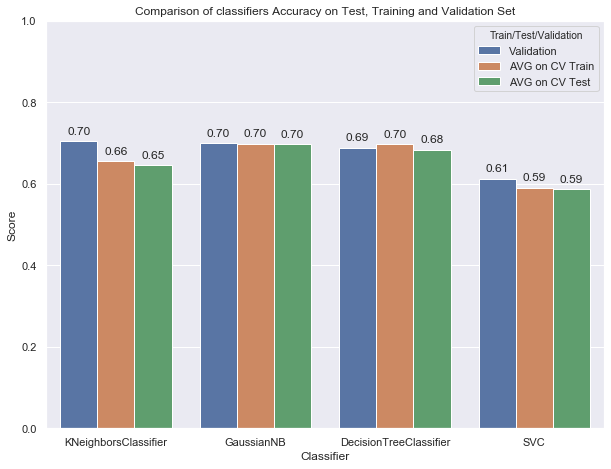

In [110]:
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x="Classifier", y="Score", hue = 'Train/Test/Validation' , data=df_graph)
ax.set_title('Comparison of classifiers Accuracy on Test, Training and Validation Set')
ax.set_ylim(0,1)
set_bar_amount(ax)

By analysing the bar chart above we can see that:

* The models wich high Accuracy in binary classification task were KNN and GaussianNB;
* The KNN have a significantly difference in scores of CV and the validation test;
* The model with the lowest accuracy were the SVM

Based on that, **we will chose the GaussianNB as the best model, since it had no difference between CV scores and the score with the validation test**.

### Cats/Dogs

In this section we will **test the best model for each classifier that we train in binary classification, but for dog and cats segment.**

We start by making a copy of df_main_cats/dogs dataframe, to use in that section.

In [111]:
df_main_cats_binary = df_main_cats.copy()
df_main_dogs_binary = df_main_dogs.copy()

Then we encode the dataframes with the segmented data.

In [112]:
#CATS
df_main_cats_binary = one_hot_encoding_columns(df_main_cats_binary, onehot_encode_columns)
df_main_cats_binary = binary_encode_columns(df_main_cats_binary, binary_encode_columns_encode)
df_main_cats_binary = binary_encode_columns(df_main_cats_binary, ['Adopted'])
#DOGS
df_main_dogs_binary = one_hot_encoding_columns(df_main_dogs_binary, onehot_encode_columns)
df_main_dogs_binary = binary_encode_columns(df_main_dogs_binary, binary_encode_columns_encode)
df_main_dogs_binary = binary_encode_columns(df_main_dogs_binary, ['Adopted'])

Create dataframe to save cats/dogs scores. We will use that dataframe to plot the results.

In [113]:
df_cats_dogs_evaluation = pd.DataFrame(columns = {'Classifier','Accuracy','Cats/Dogs'})

For each of the classifiers:

1.  Get the best model from results folder;
2.  Get the best features that was used to train the best model, from the DataFrame with the results;
3.  Splits the data to get a test set of 10%;
4.  Run the best model score function, with the test data, and obtain the result.

In this cell we create a generic function to do that.

In [114]:
def cats_dogs_score(df, best_model_find, best_features, binary_classification):
    X, y, features, target = get_data(df, best_features, binary_classification)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45, test_size=0.1)
    return best_model_find.score(X_test, y_test)

**Decision Tree**

In this section we will get the best decision tree find in section 3.4.1, and use it with cats/dogs data.

In [115]:
#GET THE BEST MODEL
best_dt_model = pickle.load(open('{}/best_model.sav'.format(results_binary_dt_folder), 'rb'))
#GET THE BEST FEATURES OF THAT MODEL
best_dt_features = df_evaluation_dt.loc[0,'Features'].replace("[",'').replace("]",'').replace('\'','').replace(" ", "").split(',')

#CATS
cats_score = cats_dogs_score(df_main_cats_binary, best_dt_model, best_dt_features, True)
row = {'Classifier':'DecisionTree','Accuracy': cats_score, 'Cats/Dogs':'Cats'}
df_cats_dogs_evaluation = df_cats_dogs_evaluation.append(row, ignore_index=True)
print('Best Decision Tree, Score on Cats Data: {}'.format(cats_score))

#DOGS
dogs_score = cats_dogs_score(df_main_dogs_binary, best_dt_model, best_dt_features, True)
row = {'Classifier':'DecisionTree','Accuracy': dogs_score, 'Cats/Dogs':'Dogs'}
df_cats_dogs_evaluation = df_cats_dogs_evaluation.append(row, ignore_index=True)
print('Best Decision Tree, Score on Dogs Data: {}'.format(dogs_score))

Best Decision Tree, Score on Cats Data: 0.6724890829694323
Best Decision Tree, Score on Dogs Data: 0.6916461916461917


**SVM**

In this section we will get the best SVM find in section 3.4.2, and use it with cats/dogs data.

In [116]:
#GET THE BEST MODEL
best_svm_model = pickle.load(open('{}/best_model.sav'.format(results_binary_svm_folder), 'rb'))
#GET THE BEST FEATURES OF THAT MODEL
best_svm_features = str(df_evaluation_svm.loc[0,'Features']).replace("[",'').replace("]",'').replace('\'','').replace(" ", "").split(',')

#CATS
cats_score = cats_dogs_score(df_main_cats_binary, best_svm_model, best_svm_features, True)
row = {'Classifier':'SVM','Accuracy': cats_score, 'Cats/Dogs':'Cats'}
df_cats_dogs_evaluation = df_cats_dogs_evaluation.append(row, ignore_index=True)
print('Best SVM, Score on Cats Data: {}'.format(cats_score))

#DOGS
dogs_score = cats_dogs_score(df_main_dogs_binary, best_svm_model, best_svm_features, True)
row = {'Classifier':'SVM','Accuracy': dogs_score, 'Cats/Dogs':'Dogs'}
df_cats_dogs_evaluation = df_cats_dogs_evaluation.append(row, ignore_index=True)
print('Best SVM, Score on Dogs Data: {}'.format(dogs_score))

Best SVM, Score on Cats Data: 0.7379912663755459
Best SVM, Score on Dogs Data: 0.6756756756756757


**KNN**

In this section we will get the best KNN find in section 3.4.3, and use it with cats/dogs data.

In [117]:
#GET THE BEST MODEL
best_knn_model = pickle.load(open('{}/best_model.sav'.format(results_binary_knn_folder), 'rb'))
#GET THE BEST FEATURES OF THAT MODEL
best_knn_features = df_evaluation_knn.loc[0,'Features'].replace("[",'').replace("]",'').replace('\'','').replace(" ", "").split(',')

#CATS
cats_score = cats_dogs_score(df_main_cats_binary, best_knn_model, best_knn_features, True)
row = {'Classifier':'KNN','Accuracy': cats_score, 'Cats/Dogs':'Cats'}
df_cats_dogs_evaluation = df_cats_dogs_evaluation.append(row, ignore_index=True)
print('Best KNN, Score on Cats Data: {}'.format(cats_score))

#DOGS
dogs_score = cats_dogs_score(df_main_dogs_binary, best_knn_model, best_knn_features, True)
row = {'Classifier':'KNN','Accuracy': dogs_score, 'Cats/Dogs':'Dogs'}
df_cats_dogs_evaluation = df_cats_dogs_evaluation.append(row, ignore_index=True)
print('Best KNN, Score on Dogs Data: {}'.format(dogs_score))

Best KNN, Score on Cats Data: 0.7030567685589519
Best KNN, Score on Dogs Data: 0.6855036855036855


**Naive Beyes**

In this section we will get the best NB find in section 3.4.4, and use it with cats/dogs data.

In [118]:
#GET THE BEST MODEL
best_nb_model = pickle.load(open('{}/best_model.sav'.format(results_binary_nb_folder), 'rb'))
#GET THE BEST FEATURES OF THAT MODEL
best_nb_features = df_evaluation_nb.loc[0,'Features'].replace("[",'').replace("]",'').replace('\'','').replace(" ", "").split(',')

#CATS
cats_score = cats_dogs_score(df_main_cats_binary, best_nb_model, best_nb_features, True)
row = {'Classifier':'Naive Bayes','Accuracy': cats_score, 'Cats/Dogs':'Cats'}
df_cats_dogs_evaluation = df_cats_dogs_evaluation.append(row, ignore_index=True)
print('Best NB, Score on Cats Data: {}'.format(cats_score))

#DOGS
dogs_score = cats_dogs_score(df_main_dogs_binary, best_nb_model, best_nb_features, True)
row = {'Classifier':'Naive Bayes','Accuracy': dogs_score, 'Cats/Dogs':'Dogs'}
df_cats_dogs_evaluation = df_cats_dogs_evaluation.append(row, ignore_index=True)
print('Best NB, Score on Dogs Data: {}'.format(dogs_score))

Best NB, Score on Cats Data: 0.7132459970887919
Best NB, Score on Dogs Data: 0.6621621621621622


**Plot it**

Here we will plot a bar chart to see, for the best model finded for each classifier, how it will perform it the segmented data

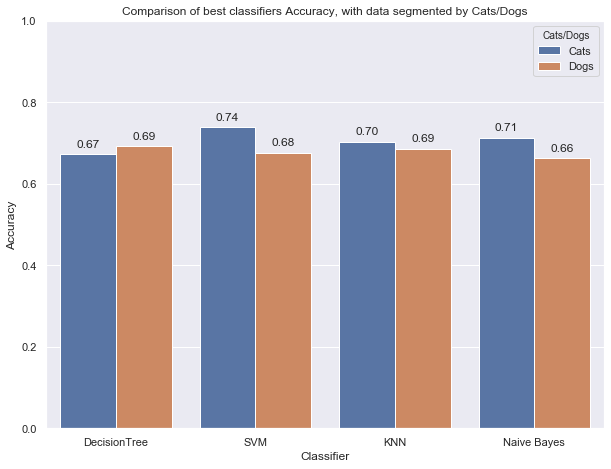

In [119]:
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x="Classifier", y="Accuracy", hue = 'Cats/Dogs' , data=df_cats_dogs_evaluation)
ax.set_title('Comparison of best classifiers Accuracy, with data segmented by Cats/Dogs')
ax.set_ylim(0,1)
set_bar_amount(ax)

By analysis the char above we can see that:

1. SVMs are the model who fits better for the Cats Data, with 0.74 Accuracy;
2. Model which fits better to the Dogs data are the KNN and Decision Trees, with 0.69 Accuracy Obtained;
3. SVMs had a bad performance with the complete databaset (0.61 Accuracy in validation set), by it segmented data it fits better;

## **Predict Adoption Speed (multiclass classification)**

In this section we will follow the same structure as the used in binary classification task.

We start by getting the data, and then enconde the necessary columns, as defined in section 3.3.3

In [120]:
#GET DATA
df_X, df_y, features, target = get_data(df_main, df_main.columns, False)
#ENCODE THE TARGET
df_y = binary_encode_columns(df_y, ['AdoptionSpeed'])
#BINARY ENCODING
df_X = binary_encode_columns(df_X, binary_encode_columns_encode)
#ONE HOT ENCODING
df_X = one_hot_encoding_columns(df_X, onehot_encode_columns)

Then we get the 7 more important features, according to the Random Forest, and then we filter the dataset according to those features.

In [121]:
more_important_columns = list(df_feature_importances.loc[0:7]['column'])
df_X = df_X[df_X.columns[df_X.columns.isin(more_important_columns)]]

### Tree Models (Decision Tree)

In [122]:
run_dt_mc = False

In this section we will train a **bunch of combinations of Decision Tree models to see which works better**:


*   We will use resampling SMOTETomek algorithm;
*   5 Fold cross validation;
*   Two Different split criterions (entropy or gini-index);
*   All possible combination of features,between 2 and 5, within the top 7 features of the random forest;
*   The results will be saved in a CSV;
*   The best model finded will be saved as a .sav file.

First we ensure that the folder where the data will be saved exists

In [123]:
#create folder to save multiclassification decision tree results
results_multi_dt_folder = '{}/decision_tree'.format(results_multi_folder)
Path(results_multi_dt_folder).mkdir(parents=True, exist_ok=True)

In [124]:
if run_dt_mc == True:
    
    params = {'criterion': ['entropy','gini']}
    kf_5 = KFold(n_splits=5, random_state=42, shuffle=False)
    df_evaluation_mc_dt, best_score_find, best_model_find = feature_combinator(df_X, df_y, df_X.columns,SMOTETomek,tree.DecisionTreeClassifier, params,kf_5, True)
    
    #SAVE BEST MODEL TO DIRECTORY
    best_model_name = 'best_model.sav'
    pickle.dump(best_model_find, open('{}/{}'.format(results_multi_dt_folder,best_model_name), 'wb'))
    
    #SAVE DATAFRAME RESULTS TO CSV
    dt_binary_evaluation_csv_path = '{}/df_evaluation_mc_dt.csv'.format(results_multi_dt_folder)
    df_evaluation_mc_dt.to_csv(dt_binary_evaluation_csv_path, sep = ';', index = False)

    #READ RESULTS THAT ARE IN THE FOLDER
else: df_evaluation_mc_dt = pd.read_csv('{}/{}'.format(results_multi_dt_folder, 'df_evaluation_mc_dt.csv'), sep = ';') 

In [125]:
df_evaluation_mc_dt

,Classifier,best_HP,Features,Accuracy,Precision,Mean_CV_Train_Accuracy,Mean_CV_Test_Accuracy,AUC
0,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'gini'},"['Breed1', 'Sterilized', 'Age_0', 'Age_2']",0.356000,0.356000,0.371044,0.324836,0
1,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Breed1', 'State', 'PhotoAmt', 'Age_0', 'Age_2']",0.340000,0.340000,0.495368,0.321130,0
2,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Breed1', 'Color1', 'Sterilized', 'Age_0']",0.340000,0.340000,0.403237,0.335509,0
3,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Breed1', 'PhotoAmt', 'Age_0']",0.338667,0.338667,0.421719,0.332581,0
4,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'gini'},"['Breed1', 'Sterilized', 'State', 'Age_0', 'Ag...",0.338000,0.338000,0.409147,0.322094,0
...,...,...,...,...,...,...,...,...
205,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Color2', 'State', 'Age_2']",0.212000,0.212000,0.260857,0.237494,0
206,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Color1', 'Color2']",0.211333,0.211333,0.213870,0.199660,0
207,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'entropy'},"['Color2', 'Age_2']",0.210667,0.210667,0.243330,0.242570,0
208,DecisionTreeClassifier,{'decisiontreeclassifier__criterion': 'gini'},"['Color2', 'State']",0.200000,0.200000,0.224032,0.204737,0


### Linear Models (SVM)

In [126]:
run_svm_mc = False

In this section we will train a **bunch of combinations of Support Vector Machines to see which works better**:


*   We will use resampling SMOTETomek algorithm;
*   5 Fold cross validation;
*   Different combinations of 'gamma' and 'C' hyperparameters;
*   All possible combination of features,between 3 and 5, within the top 5 features of the random forest;
*   The results will be saved in a CSV;
*   The best model finded will be saved as a .sav file.

Ensure that the output folder exists

In [127]:
#create folder to save multiclassification decision tree results
results_multi_svm_folder = '{}/svm'.format(results_multi_folder)
Path(results_multi_svm_folder).mkdir(parents=True, exist_ok=True)

Just like in binary svm model training, get just the top 5 columns, and do combinations of 3, 4 and 5.

In [128]:
more_important_columns = list(df_feature_importances.loc[0:5]['column'])
df_X_svm = df_X[df_X.columns[df_X.columns.isin(more_important_columns)]].copy()

Standardize the data

In [129]:
df_X_svm_cc = df_X_svm.copy()
df_X_svm_cc = standardize_data(df_X_svm_cc, df_X_svm_cc.columns)

In [130]:
if run_svm_mc == True:
    params = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100]}
    kf_5 = KFold(n_splits=5, random_state=42, shuffle=False)
    df_evaluation_mc_svm, best_score_find, best_model_find = feature_combinator(df_X_svm_cc, df_y, df_X_svm_cc.columns, SMOTETomek, SVC, params, kf_5, True, 3, 5)
    
    #SAVE BEST MODEL TO DIRECTORY
    best_model_name = 'best_model.sav'
    pickle.dump(best_model_find, open('{}/{}'.format(results_multi_svm_folder,best_model_name), 'wb'))
    
    #SAVE DATAFRAME RESULTS TO CSV
    svm_binary_evaluation_csv_path = '{}/df_evaluation_mc_svm.csv'.format(results_multi_svm_folder)
    df_evaluation_mc_svm.to_csv(svm_binary_evaluation_csv_path, sep = ';', index = False)

    #READ RESULTS THAT ARE IN THE FOLDER
else: df_evaluation_mc_svm = pd.read_csv('{}/{}'.format(results_multi_svm_folder, 'df_evaluation_mc_svm.csv'), sep = ';') 
    

In [131]:
df_evaluation_mc_svm

,Classifier,best_HP,Features,Accuracy,Precision,Mean_CV_Train_Accuracy,Mean_CV_Test_Accuracy,AUC
0,SVC,"{'svc__C': 1, 'svc__gamma': 0.001, 'svc__kerne...","['Color1', 'State', 'Age_0']",0.336000,0.336000,0.328513,0.326021,0
1,SVC,"{'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kern...","['Color1', 'Color2', 'Age_0']",0.332000,0.332000,0.332290,0.330640,0
2,SVC,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kern...","['Color2', 'State', 'Age_0']",0.325333,0.325333,0.314966,0.313052,0
3,SVC,"{'svc__C': 10, 'svc__gamma': 0.0001, 'svc__ker...","['Breed1', 'Color2', 'Age_0']",0.324000,0.324000,0.312863,0.311519,0
4,SVC,"{'svc__C': 1, 'svc__gamma': 0.001, 'svc__kerne...","['Breed1', 'State', 'Age_0']",0.324000,0.324000,0.319672,0.317510,0
5,SVC,"{'svc__C': 1, 'svc__gamma': 0.001, 'svc__kerne...","['Breed1', 'Color1', 'State', 'Age_0']",0.324000,0.324000,0.325162,0.324132,0
6,SVC,"{'svc__C': 100, 'svc__gamma': 0.0001, 'svc__ke...","['Color2', 'PhotoAmt', 'Age_0']",0.323333,0.323333,0.303661,0.301612,0
7,SVC,"{'svc__C': 10, 'svc__gamma': 0.0001, 'svc__ker...","['Breed1', 'Color1', 'Age_0']",0.323333,0.323333,0.324937,0.324761,0
8,SVC,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kern...","['State', 'PhotoAmt', 'Age_0']",0.323333,0.323333,0.299091,0.296150,0
9,SVC,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...","['Color1', 'PhotoAmt', 'Age_0']",0.322667,0.322667,0.301286,0.297462,0


### Distance Based Model (KNN)

In [132]:
run_knn_mc = False

In this section we will train a **bunch of combinations of KNN to see which works better**:


*   We will use resampling SMOTETomek algorithm;
*   5 Fold cross validation;
*   For each combination of features, we will test three differents K: 3,5 and 7;
*   All possible combination of features,between 2 and 5, within the top 7 features of the random forest
*   The best 5 results will be saved in a CSV;
*   The best model finded will be saved as a .sav file.

Ensure that the folder exists

In [133]:
#create folder to save multiclassification decision tree results
results_multi_knn_folder = '{}/knn'.format(results_multi_folder)
Path(results_multi_knn_folder).mkdir(parents=True, exist_ok=True)

In [134]:
if run_knn_mc == True:
    kf_5 = KFold(n_splits=5, random_state=42, shuffle=False)
    params = {'n_neighbors': [3,5,7]}
    df_evaluation_mc_knn, best_score_find, best_model_find = feature_combinator(df_X, df_y, df_X.columns, SMOTETomek, neighbors.KNeighborsClassifier, params,kf_5, True)
    
    #SAVE BEST MODEL TO DIRECTORY
    best_model_name = 'best_model.sav'
    pickle.dump(best_model_find, open('{}/{}'.format(results_multi_knn_folder,best_model_name), 'wb'))
    
    #SAVE DATAFRAME RESULTS TO CSV
    knn_binary_evaluation_csv_path = '{}/df_evaluation_mc_knn.csv'.format(results_multi_knn_folder)
    df_evaluation_mc_knn.to_csv(knn_binary_evaluation_csv_path, sep = ';', index = False)

    #READ RESULTS THAT ARE IN THE FOLDER
else: df_evaluation_mc_knn = pd.read_csv('{}/{}'.format(results_multi_knn_folder, 'df_evaluation_mc_knn.csv'), sep = ';') 

In [135]:
df_evaluation_mc_knn

,Classifier,best_HP,Features,Accuracy,Precision,Mean_CV_Train_Accuracy,Mean_CV_Test_Accuracy,AUC
0,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 5},"['Age_0', 'Age_2']",0.334667,0.334667,0.237475,0.240717,0
1,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Breed1', 'State', 'Age_0', 'Age_2']",0.332000,0.332000,0.298290,0.255738,0
2,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Breed1', 'State', 'PhotoAmt', 'Age_0']",0.323333,0.323333,0.374404,0.288469,0
3,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Breed1', 'State', 'PhotoAmt', 'Age_0', 'Age_2']",0.322000,0.322000,0.383112,0.285555,0
4,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Breed1', 'Age_0', 'Age_2']",0.321333,0.321333,0.280485,0.265816,0
...,...,...,...,...,...,...,...,...
205,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Color1', 'Color2', 'Sterilized', 'Age_0']",0.192667,0.192667,0.239013,0.230415,0
206,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 5},"['Color1', 'Color2']",0.189333,0.189333,0.190309,0.188096,0
207,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Color2', 'Sterilized', 'State']",0.184667,0.184667,0.214302,0.198796,0
208,KNeighborsClassifier,{'kneighborsclassifier__n_neighbors': 7},"['Color1', 'Color2', 'Age_2']",0.176000,0.176000,0.206200,0.200005,0


### Probablistic Model (Naive Bayes)

In [136]:
run_nb_mc = False

In this section we will train a **bunch of combinations of Naive Bayes GaussianNB altgorithm, to see which works better**:


*   We will use resampling SMOTETomek algorithm;
*   5 Fold cross validation;
*   We will test different types of hyperparameters;
*   All possible combination of features,between 2 and 5, within the top 7 features of the random forest;
*   The results will be saved in a CSV;
*   The best model finded will be saved as a .sav file.

In [137]:
#create folder to save multiclassification decision tree results
results_multi_nb_folder = '{}/nb'.format(results_multi_folder)
Path(results_multi_nb_folder).mkdir(parents=True, exist_ok=True)

In [138]:
if run_nb_mc == True:
    kf_5 = KFold(n_splits=5, random_state=42, shuffle=False)
    params = {}
    df_evaluation_mc_nb, best_score_find, best_model_find = feature_combinator(df_X, df_y, df_X.columns, SMOTETomek, GaussianNB, params, kf_5, True)
    
    #SAVE BEST MODEL TO DIRECTORY
    best_model_name = 'best_model.sav'
    pickle.dump(best_model_find, open('{}/{}'.format(results_multi_nb_folder,best_model_name), 'wb'))
    
    #SAVE DATAFRAME RESULTS TO CSV
    nb_binary_evaluation_csv_path = '{}/df_evaluation_mc_nb.csv'.format(results_multi_nb_folder)
    df_evaluation_mc_nb.to_csv(nb_binary_evaluation_csv_path, sep = ';', index = False)

    #READ RESULTS THAT ARE IN THE FOLDER
else: df_evaluation_mc_nb = pd.read_csv('{}/{}'.format(results_multi_nb_folder, 'df_evaluation_mc_nb.csv'), sep = ';') 
    

In [139]:
df_evaluation_mc_nb

,Classifier,best_HP,Features,Accuracy,Precision,Mean_CV_Train_Accuracy,Mean_CV_Test_Accuracy,AUC
0,GaussianNB,{},"['Color1', 'State', 'Age_0']",0.336667,0.336667,0.333488,0.332322,0
1,GaussianNB,{},"['Breed1', 'Color1', 'State', 'Age_0', 'Age_2']",0.334667,0.334667,0.330468,0.330098,0
2,GaussianNB,{},"['Breed1', 'Color1', 'Age_0', 'Age_2']",0.332667,0.332667,0.331246,0.331136,0
3,GaussianNB,{},"['Breed1', 'Age_0', 'Age_2']",0.332667,0.332667,0.325706,0.323204,0
4,GaussianNB,{},"['Breed1', 'State', 'Age_0', 'Age_2']",0.330000,0.330000,0.330208,0.327208,0
...,...,...,...,...,...,...,...,...
205,GaussianNB,{},"['Color1', 'Color2', 'Sterilized', 'State']",0.138000,0.138000,0.146076,0.145780,0
206,GaussianNB,{},"['Color1', 'PhotoAmt']",0.131333,0.131333,0.130124,0.128657,0
207,GaussianNB,{},"['Color2', 'PhotoAmt']",0.119333,0.119333,0.149318,0.147929,0
208,GaussianNB,{},"['Color1', 'State', 'PhotoAmt']",0.119333,0.119333,0.128178,0.125397,0


### Comparison of Classifiers

In this section we will plot a bar chart to **compare the differences in Accuracy of the best models found for each category (KNN, SVM, DT & NB)**

We start by merging the dataframes with the results of models creation, into a single dataframe. 

In [140]:
df_dfs_scores_mc = [df_evaluation_mc_dt, df_evaluation_mc_svm, df_evaluation_mc_nb, df_evaluation_mc_knn]
df_comparison_mc = pd.concat(df_dfs_scores_mc)

Then we make a little preprocessing on the data, to plot it after:

1.   **For each one of the classifiers, get the best: the one with the highest 'Accuracy'**, and add it to a dataframe that will be used to plot the data;
2.   For the best model found for each of the classifiers, add three records to the dataframe: **One with the Mean Accuracy on Cross Validation Training data**; other with the **Mean Accuracy on Cross Validation in Test data**; and the other with the **Accuracy on the validation set**.

In [141]:
lst_classifiers = list(df_comparison_mc['Classifier'].unique())
df_graph = pd.DataFrame(columns={'Classifier', 'Train/Test/Validation', 'Score'})
for c in lst_classifiers:
    
    c_best = df_comparison_mc[df_comparison_mc['Classifier'] == c].sort_values(by= 'Accuracy', ascending = False).head(1)
    
    row_train = {'Classifier': c, 'Train/Test/Validation': 'AVG on CV Train', 'Score': float(c_best['Mean_CV_Train_Accuracy'])}
    row_test = {'Classifier': c, 'Train/Test/Validation': 'AVG on CV Test', 'Score': float(c_best['Mean_CV_Test_Accuracy'])}
    row_validation_test = {'Classifier': c, 'Train/Test/Validation': 'Validation', 'Score': float(c_best['Accuracy'])}
    
    df_graph = df_graph.append(row_train, ignore_index=True)
    df_graph = df_graph.append(row_test, ignore_index=True)
    df_graph = df_graph.append(row_validation_test, ignore_index=True)

df_graph = df_graph.sort_values(by='Score', ascending = False)

Plot it

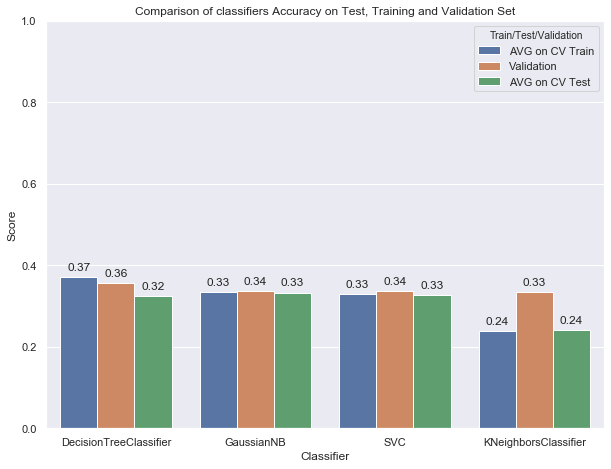

In [142]:
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x="Classifier", y="Score", hue = 'Train/Test/Validation' , data=df_graph)
ax.set_title('Comparison of classifiers Accuracy on Test, Training and Validation Set')
ax.set_ylim(0,1)
set_bar_amount(ax)

The best score should be seen with the AVG on Test set and by comparing with the AVG on Train and Validation set we can see if there is overfitting or not.

Considering this, the Decidion Tree Classifier seems to show some overfitting since the CV on the Test set has a smaller accuracy than with the Train and Validation set. But the GaussianNB and SVC have very similar scores with the Train, Validation and Test set and we can also note that they have the highest score with the Test set (33%). KNeighbors has a lower accuracy than the rest as it can be easily seen in the bar plot above.

We can therefore conclude that GaussianNB and SVC are the best classifiers for this dataset and potentially the Decision Tree Classifier as well if we are careful with the overfitting.

### Cats/Dogs

In this section we will **test the best model for each classifier that we train in multi classification, but now for the dog and cat's segment.**

We start by making a copy of df_main_cats/dogs dataframe, to use in that section.

In [143]:
df_main_cats_multi = df_main_cats.copy()
df_main_dogs_multi = df_main_dogs.copy()

Then we encode the dataframes with the segmented data.

In [144]:
#CATS
df_main_cats_multi = one_hot_encoding_columns(df_main_cats_multi, onehot_encode_columns)
df_main_cats_multi = binary_encode_columns(df_main_cats_multi, binary_encode_columns_encode)
df_main_cats_multi = binary_encode_columns(df_main_cats_multi, ['AdoptionSpeed'])
#DOGS
df_main_dogs_multi = one_hot_encoding_columns(df_main_dogs_multi, onehot_encode_columns)
df_main_dogs_multi = binary_encode_columns(df_main_dogs_multi, binary_encode_columns_encode)
df_main_dogs_multi = binary_encode_columns(df_main_dogs_multi, ['AdoptionSpeed'])

Create dataframe to save cats/dogs scores. We will use that dataframe to plot the results.

In [145]:
df_cats_dogs_evaluation_mc = pd.DataFrame(columns = {'Classifier','Accuracy','Cats/Dogs'})

For each of the classifiers:

1.  Get the best model from results folder;
2.  Get the best features that were used to train the best model, from the DataFrame with the results;
3.  Split the data to get a test set of 10%;
4.  Run the best model score function with the test data, and obtain the result.

**Decision Tree**

In this section we will get the best decision tree found in section 3.5.1, and use it with cats/dogs data.

In [146]:
#GET THE BEST MODEL
best_dt_model = pickle.load(open('{}/best_model.sav'.format(results_multi_dt_folder), 'rb'))
#GET THE BEST FEATURES OF THAT MODEL
best_dt_features = df_evaluation_mc_dt.loc[0,'Features'].replace("[",'').replace("]",'').replace('\'','').replace(" ", "").split(',')

#CATS
cats_score = cats_dogs_score(df_main_cats_multi, best_dt_model, best_dt_features, False)
row = {'Classifier':'DecisionTree','Accuracy': cats_score, 'Cats/Dogs':'Cats'}
df_cats_dogs_evaluation_mc = df_cats_dogs_evaluation_mc.append(row, ignore_index=True)
print('Best Decision Tree, Score on Cats Data: {}'.format(cats_score))

#DOGS
dogs_score = cats_dogs_score(df_main_dogs_multi, best_dt_model, best_dt_features, False)
row = {'Classifier':'DecisionTree','Accuracy': dogs_score, 'Cats/Dogs':'Dogs'}
df_cats_dogs_evaluation_mc = df_cats_dogs_evaluation_mc.append(row, ignore_index=True)
print('Best Decision Tree, Score on Dogs Data: {}'.format(dogs_score))

Best Decision Tree, Score on Cats Data: 0.33624454148471616
Best Decision Tree, Score on Dogs Data: 0.3955773955773956


**SVM**

In this section we will get the best SVM found in section 3.5.2, and use it with cats/dogs data.

In [147]:
#GET THE BEST MODEL
best_svm_model = pickle.load(open('{}/best_model.sav'.format(results_multi_svm_folder), 'rb'))
#GET THE BEST FEATURES OF THAT MODEL
best_svm_features = df_evaluation_mc_svm.loc[0,'Features'].replace("[",'').replace("]",'').replace('\'','').replace(" ", "").split(',')

#CATS
cats_score = cats_dogs_score(df_main_cats_multi, best_svm_model, best_svm_features, False)
row = {'Classifier':'SVM','Accuracy': cats_score, 'Cats/Dogs':'Cats'}
df_cats_dogs_evaluation_mc = df_cats_dogs_evaluation_mc.append(row, ignore_index=True)
print('Best SVM, Score on Cats Data: {}'.format(cats_score))

#DOGS
dogs_score = cats_dogs_score(df_main_dogs_multi, best_svm_model, best_svm_features, False)
row = {'Classifier':'SVM','Accuracy': dogs_score, 'Cats/Dogs':'Dogs'}
df_cats_dogs_evaluation_mc = df_cats_dogs_evaluation_mc.append(row, ignore_index=True)
print('Best SVM, Score on Dogs Data: {}'.format(dogs_score))

Best SVM, Score on Cats Data: 0.25036390101892286
Best SVM, Score on Dogs Data: 0.25184275184275184


**KNN**

In this section we will get the best KNN found in section 3.5.3, and use it with cats/dogs data.

In [148]:
#GET THE BEST MODEL
best_knn_model = pickle.load(open('{}/best_model.sav'.format(results_multi_knn_folder), 'rb'))
#GET THE BEST FEATURES OF THAT MODEL
best_knn_features = df_evaluation_mc_knn.loc[0,'Features'].replace("[",'').replace("]",'').replace('\'','').replace(" ", "").split(',')

#CATS
cats_score = cats_dogs_score(df_main_cats_multi, best_knn_model, best_knn_features, False)
row = {'Classifier':'KNN','Accuracy': cats_score, 'Cats/Dogs':'Cats'}
df_cats_dogs_evaluation_mc = df_cats_dogs_evaluation_mc.append(row, ignore_index=True)
print('Best KNN, Score on Cats Data: {}'.format(cats_score))

#DOGS
dogs_score = cats_dogs_score(df_main_dogs_multi, best_knn_model, best_knn_features, False)
row = {'Classifier':'KNN','Accuracy': dogs_score, 'Cats/Dogs':'Dogs'}
df_cats_dogs_evaluation_mc = df_cats_dogs_evaluation_mc.append(row, ignore_index=True)
print('Best KNN, Score on Dogs Data: {}'.format(dogs_score))

Best KNN, Score on Cats Data: 0.32168850072780203
Best KNN, Score on Dogs Data: 0.35626535626535627


**Naive Beyes**

In this section we will get the best Naive Beyes found in section 3.5.4, and use it with cats/dogs data.

In [149]:
#GET THE BEST MODEL
best_nb_model = pickle.load(open('{}/best_model.sav'.format(results_multi_nb_folder), 'rb'))
#GET THE BEST FEATURES OF THAT MODEL
best_nb_features = df_evaluation_mc_nb.loc[0,'Features'].replace("[",'').replace("]",'').replace('\'','').replace(" ", "").split(',')

#CATS
cats_score = cats_dogs_score(df_main_cats_multi, best_nb_model, best_nb_features, False)
row = {'Classifier':'Naive Bayes','Accuracy': cats_score, 'Cats/Dogs':'Cats'}
df_cats_dogs_evaluation_mc = df_cats_dogs_evaluation_mc.append(row, ignore_index=True)
print('Best NB, Score on Cats Data: {}'.format(cats_score))

#DOGS
dogs_score = cats_dogs_score(df_main_dogs_multi, best_nb_model, best_nb_features, False)
row = {'Classifier':'Naive Bayes','Accuracy': dogs_score, 'Cats/Dogs':'Dogs'}
df_cats_dogs_evaluation_mc = df_cats_dogs_evaluation_mc.append(row, ignore_index=True)
print('Best NB, Score on Dogs Data: {}'.format(dogs_score))

Best NB, Score on Cats Data: 0.34934497816593885
Best NB, Score on Dogs Data: 0.343980343980344


**Plot it**

Here we will plot a bar chart to see, for the best model found for each classifier, how it will perform in the segmented data

In [ ]:
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x="Classifier", y="Accuracy", hue = 'Cats/Dogs' , data=df_cats_dogs_evaluation_mc)
ax.set_title('Comparison of best classifiers Accuracy, with data segmented by Cats/Dogs')
ax.set_ylim(0,1)
set_bar_amount(ax)

In this case we are only seeing the final result from running the classifiers on a validation set. The results are varying for Cats and Dogs with Decision Tree classifier performing best for Dogs (40%) and Naive Bayes for Cats (35%).